In [8]:
!pip install optuna

## change the formatting

In [2]:
import pandas as pd

# Load the dataset
df = pd.read_csv("/content/ccd_data.csv")


# Convert 'Date' column to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Ensure correct numeric types
df['Rate'] = pd.to_numeric(df['Rate'], errors='coerce')
df['Quantity'] = pd.to_numeric(df['Quantity'], errors='coerce')
df['Discount'] = pd.to_numeric(df['Discount'], errors='coerce')

# Calculate Sales Amount and Net Sales
df['Sales Amount'] = df['Rate'] * df['Quantity']
df['Net Sales'] = df['Sales Amount'] - df['Discount']

# Extract Year from Date
df['Year'] = df['Date'].dt.year

# Select and reorder the columns
final_df = df[['Item Name', 'Rate', 'Quantity', 'Sales Amount', 'Discount', 'Net Sales', 'Date', 'Year']]

# Drop rows with missing data
final_df.dropna(inplace=True)

# Preview the cleaned and formatted data
print(final_df.head())

# Optional: Save to a new file
final_df.to_csv('Formatted_Sales_Data.csv', index=False)


                                 Item Name    Rate  Quantity  Sales Amount  \
0                  Signature Choco Fantasy  173.56        60      10413.60   
1              Classic New York Cheesecake  180.56        53       9569.68   
2  Tandoori Chicken Double Decker Sandwich  172.51        68      11730.68   
3                  Signature Choco Fantasy  173.56        51       8851.56   
4          Cheese Tomato Croissant Sliders  141.44        60       8486.40   

   Discount  Net Sales       Date  Year  
0    275.40   10138.20 2023-01-01  2023  
1     55.12    9514.56 2023-01-01  2023  
2    228.48   11502.20 2023-01-01  2023  
3    234.09    8617.47 2023-01-01  2023  
4    198.60    8287.80 2023-01-14  2023  


<ipython-input-2-00b48e691580>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df.dropna(inplace=True)


## Randomforest:

[I 2025-04-21 10:08:31,410] A new study created in memory with name: no-name-7173e7e3-4b33-4e2a-8301-45b2159ef82d
[I 2025-04-21 10:08:33,839] Trial 0 finished with value: 0.10511476965034436 and parameters: {'n_estimators': 144, 'max_depth': 20, 'min_samples_split': 8, 'min_samples_leaf': 6, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.10511476965034436.
[I 2025-04-21 10:08:34,891] Trial 1 finished with value: 0.1058139426019021 and parameters: {'n_estimators': 64, 'max_depth': 18, 'min_samples_split': 7, 'min_samples_leaf': 8, 'max_features': 'log2'}. Best is trial 0 with value: 0.10511476965034436.
[I 2025-04-21 10:08:37,113] Trial 2 finished with value: 0.10667277116510195 and parameters: {'n_estimators': 258, 'max_depth': 6, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 0 with value: 0.10511476965034436.
[I 2025-04-21 10:08:38,562] Trial 3 finished with value: 0.10524149959074972 and parameters: {'n_estimators': 158, 'max_depth': 8,

Best Parameters: {'n_estimators': 170, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}
MAE: 6898.01, RMSE: 9105.37, MSE: 82907726.70, R²: 0.8509
Normalized MAE: 0.1344, Normalized RMSE: 0.1774


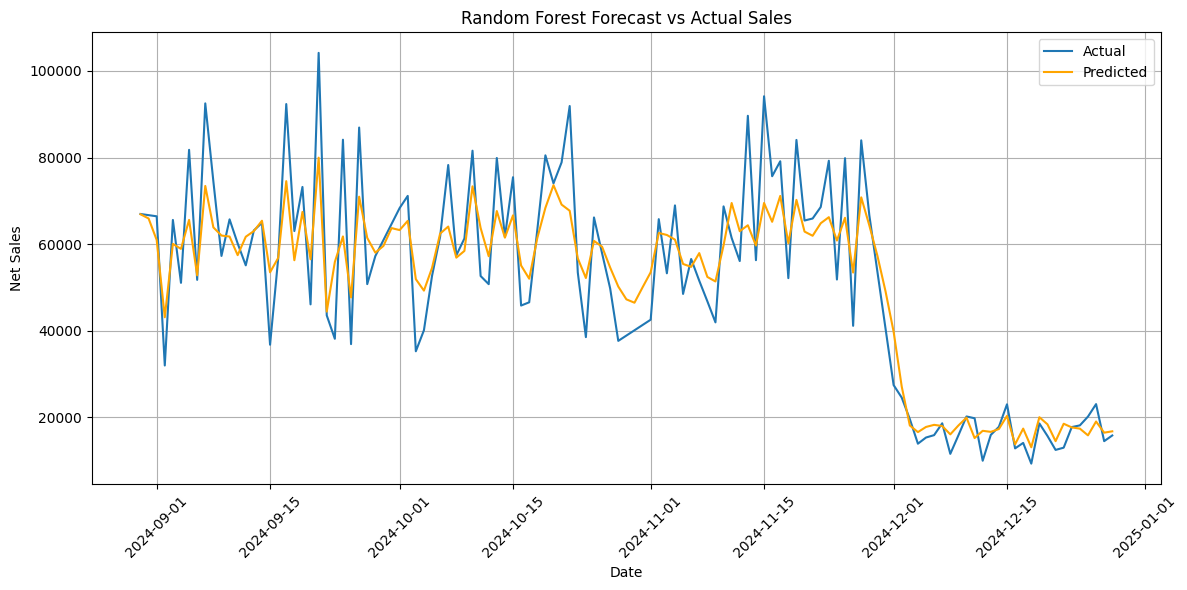

In [10]:
# !pip install optuna
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
import optuna
import joblib

# Set global seed
SEED = 42
np.random.seed(SEED)

# Load and preprocess dataset
df = pd.read_csv("/content/Formatted_Sales_Data.csv")
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df.sort_index(inplace=True)

# Feature engineering
df['discount_rate'] = df['Discount'] / df['Sales Amount']
df['unit_price'] = df['Net Sales'] / df['Quantity']
df['quantity_discount_interaction'] = df['Quantity'] * df['Discount']
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)

# Aggregate to daily
daily = df.groupby('Date').agg({
    'Net Sales': 'sum',
    'discount_rate': 'mean',
    'unit_price': 'mean',
    'quantity_discount_interaction': 'sum'
}).asfreq('D')

# Fill missing days using interpolation
daily.interpolate(method='linear', inplace=True)
daily.dropna(inplace=True)

# Lag features
n_lags = 2  # Reduced from 4 to prevent empty dataset
features = ['Net Sales', 'discount_rate', 'unit_price', 'quantity_discount_interaction']
for lag in range(1, n_lags + 1):
    for col in features:
        daily[f"{col}_lag{lag}"] = daily[col].shift(lag)

# Define target
daily['target'] = daily['Net Sales']

# Drop rows where lag features or target are NaN
daily.dropna(subset=['target'] + [col for col in daily.columns if 'lag' in col], inplace=True)

# Prepare input and output
X_cols = [col for col in daily.columns if 'lag' in col]
X = daily[X_cols].values
y = daily['target'].values

# Normalize input and output
x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()
X_scaled = x_scaler.fit_transform(X)
y_scaled = y_scaler.fit_transform(y.reshape(-1, 1)).ravel()

# TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Optuna objective
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2'])
    }

    rmse_scores = []
    for train_idx, test_idx in tscv.split(X_scaled):
        X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
        y_train, y_test = y_scaled[train_idx], y_scaled[test_idx]

        model = RandomForestRegressor(**params, random_state=SEED, n_jobs=-1)
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        rmse_scores.append(np.sqrt(mean_squared_error(y_test, preds)))

    return np.mean(rmse_scores)

# Run Optuna
sampler = optuna.samplers.TPESampler(seed=SEED)
study = optuna.create_study(direction="minimize", sampler=sampler)
study.optimize(objective, n_trials=50)

# Train final model using last split
best_params = study.best_params
print("Best Parameters:", best_params)

train_idx, test_idx = list(tscv.split(X_scaled))[-1]
X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
y_train, y_test = y_scaled[train_idx], y_scaled[test_idx]

best_model = RandomForestRegressor(**best_params, random_state=SEED, n_jobs=-1)
best_model.fit(X_train, y_train)

# Predict and inverse transform
y_pred_scaled = best_model.predict(X_test)
y_pred = y_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()
y_test_original = y_scaler.inverse_transform(y_test.reshape(-1, 1)).ravel()

# Metrics
mae = mean_absolute_error(y_test_original, y_pred)
rmse = np.sqrt(mean_squared_error(y_test_original, y_pred))
mse = mean_squared_error(y_test_original, y_pred)
r2 = r2_score(y_test_original, y_pred)
mean_actual = np.mean(y_test_original)
normalized_mae = mae / mean_actual
normalized_rmse = rmse / mean_actual

print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}, MSE: {mse:.2f}, R²: {r2:.4f}")
print(f"Normalized MAE: {normalized_mae:.4f}, Normalized RMSE: {normalized_rmse:.4f}")
# Get actual dates for the x-axis
dates = daily.index[test_idx]

# Plot predictions vs actual with proper date labels
plt.figure(figsize=(12, 6))
plt.plot(dates, y_test_original, label='Actual')
plt.plot(dates, y_pred, label='Predicted', color='orange')
plt.title("Random Forest Forecast vs Actual Sales")
plt.xlabel("Date")
plt.ylabel("Net Sales")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Save model and scalers
# joblib.dump(best_model, "rf_sales_forecast.pkl")
# joblib.dump(x_scaler, "x_scaler.pkl")
# joblib.dump(y_scaler, "y_scaler.pkl")
# daily.to_csv("daily_sales_data.csv")


## Decision Tree:

[I 2025-04-21 10:13:22,811] A new study created in memory with name: no-name-bf747d4f-a8ab-4ab2-bd1c-6ff876bfbab3
[I 2025-04-21 10:13:22,823] Trial 0 finished with value: 0.11534706678742226 and parameters: {'max_depth': 9, 'min_samples_split': 10, 'min_samples_leaf': 8, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.11534706678742226.
[I 2025-04-21 10:13:22,838] Trial 1 finished with value: 0.11061646339149686 and parameters: {'max_depth': 4, 'min_samples_split': 9, 'min_samples_leaf': 7, 'max_features': None}. Best is trial 1 with value: 0.11061646339149686.
[I 2025-04-21 10:13:22,862] Trial 2 finished with value: 0.10994666523857728 and parameters: {'max_depth': 17, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': None}. Best is trial 2 with value: 0.10994666523857728.
[I 2025-04-21 10:13:22,880] Trial 3 finished with value: 0.11130558934354111 and parameters: {'max_depth': 10, 'min_samples_split': 4, 'min_samples_leaf': 7, 'max_features': None}. Best is trial 

Best Parameters: {'max_depth': 13, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': None}
MAE: 6528.89, RMSE: 9093.89, MSE: 82698749.75, R²: 0.8513
Normalized MAE: 0.1272, Normalized RMSE: 0.1772


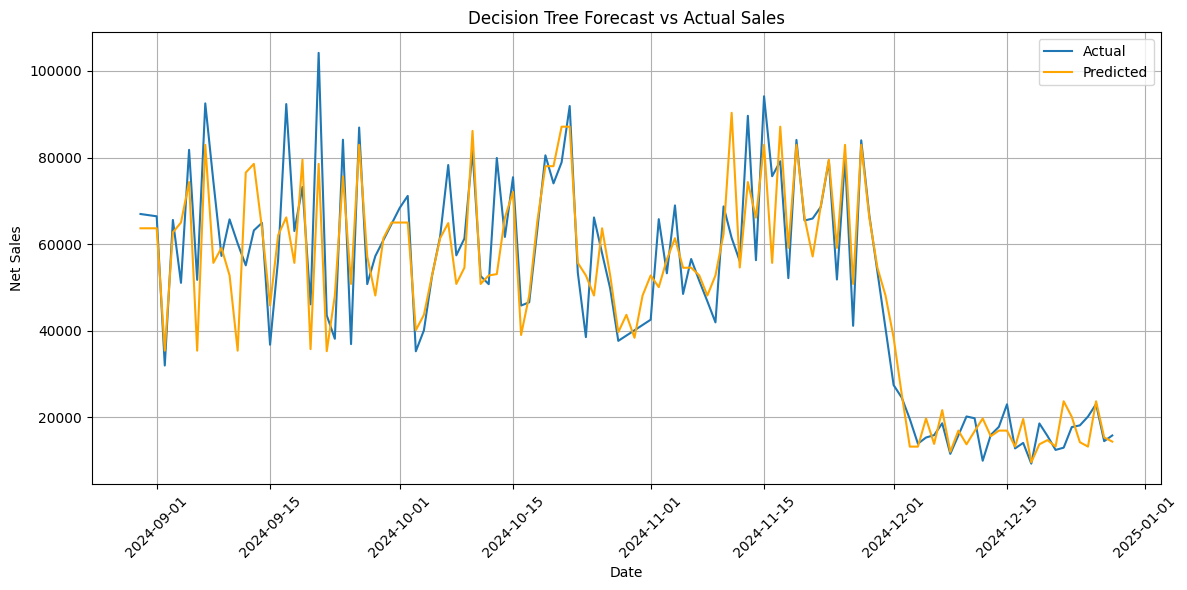

In [11]:
# !pip install optuna
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeRegressor
import optuna
import joblib

# Set global seed
SEED = 42
np.random.seed(SEED)

# Load and preprocess dataset
df = pd.read_csv("/content/Formatted_Sales_Data.csv")
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df.sort_index(inplace=True)

# Feature engineering
df['discount_rate'] = df['Discount'] / df['Sales Amount']
df['unit_price'] = df['Net Sales'] / df['Quantity']
df['quantity_discount_interaction'] = df['Quantity'] * df['Discount']
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)

# Aggregate to daily
daily = df.groupby('Date').agg({
    'Net Sales': 'sum',
    'discount_rate': 'mean',
    'unit_price': 'mean',
    'quantity_discount_interaction': 'sum'
}).asfreq('D')

# Fill missing days using interpolation
daily.interpolate(method='linear', inplace=True)
daily.dropna(inplace=True)

# Lag features
n_lags = 2  # Using 2 lags to avoid NaNs
features = ['Net Sales', 'discount_rate', 'unit_price', 'quantity_discount_interaction']
for lag in range(1, n_lags + 1):
    for col in features:
        daily[f"{col}_lag{lag}"] = daily[col].shift(lag)

# Define target
daily['target'] = daily['Net Sales']

# Drop rows with NaNs in lags or target
daily.dropna(subset=['target'] + [col for col in daily.columns if 'lag' in col], inplace=True)

# Prepare input and output
X_cols = [col for col in daily.columns if 'lag' in col]
X = daily[X_cols].values
y = daily['target'].values

# Normalize input and output
x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()
X_scaled = x_scaler.fit_transform(X)
y_scaled = y_scaler.fit_transform(y.reshape(-1, 1)).ravel()

# TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Optuna objective for Decision Tree
def objective(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None])
    }

    rmse_scores = []
    for train_idx, test_idx in tscv.split(X_scaled):
        X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
        y_train, y_test = y_scaled[train_idx], y_scaled[test_idx]

        model = DecisionTreeRegressor(**params, random_state=SEED)
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        rmse_scores.append(np.sqrt(mean_squared_error(y_test, preds)))

    return np.mean(rmse_scores)

# Run Optuna
sampler = optuna.samplers.TPESampler(seed=SEED)
study = optuna.create_study(direction="minimize", sampler=sampler)
study.optimize(objective, n_trials=50)

# Train final model using last split
best_params = study.best_params
print("Best Parameters:", best_params)

train_idx, test_idx = list(tscv.split(X_scaled))[-1]
X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
y_train, y_test = y_scaled[train_idx], y_scaled[test_idx]

best_model = DecisionTreeRegressor(**best_params, random_state=SEED)
best_model.fit(X_train, y_train)

# Predict and inverse transform
y_pred_scaled = best_model.predict(X_test)
y_pred = y_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()
y_test_original = y_scaler.inverse_transform(y_test.reshape(-1, 1)).ravel()

# Metrics
mae = mean_absolute_error(y_test_original, y_pred)
rmse = np.sqrt(mean_squared_error(y_test_original, y_pred))
mse = mean_squared_error(y_test_original, y_pred)
r2 = r2_score(y_test_original, y_pred)
mean_actual = np.mean(y_test_original)
normalized_mae = mae / mean_actual
normalized_rmse = rmse / mean_actual

print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}, MSE: {mse:.2f}, R²: {r2:.4f}")
print(f"Normalized MAE: {normalized_mae:.4f}, Normalized RMSE: {normalized_rmse:.4f}")

# Get actual dates for the x-axis
dates = daily.index[test_idx]

# Plot predictions vs actual with proper date labels
plt.figure(figsize=(12, 6))
plt.plot(dates, y_test_original, label='Actual')
plt.plot(dates, y_pred, label='Predicted', color='orange')
plt.title("Decision Tree Forecast vs Actual Sales")
plt.xlabel("Date")
plt.ylabel("Net Sales")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# # Save model and scalers
# joblib.dump(best_model, "dt_sales_forecast.pkl")
# joblib.dump(x_scaler, "x_scaler.pkl")
# joblib.dump(y_scaler, "y_scaler.pkl")
# daily.to_csv("daily_sales_data.csv")


## XGboost:

[I 2025-04-21 10:14:56,729] A new study created in memory with name: no-name-c025eccf-ff7a-4b31-836a-4b5948b07522
[I 2025-04-21 10:14:57,223] Trial 0 finished with value: 0.12777118494909004 and parameters: {'n_estimators': 144, 'max_depth': 15, 'learning_rate': 0.1205712628744377, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.5780093202212182, 'gamma': 0.7799726016810132, 'reg_alpha': 0.2904180608409973, 'reg_lambda': 4.330880728874676}. Best is trial 0 with value: 0.12777118494909004.
[I 2025-04-21 10:14:57,510] Trial 1 finished with value: 0.13685826056439743 and parameters: {'n_estimators': 200, 'max_depth': 12, 'learning_rate': 0.010725209743171997, 'subsample': 0.9849549260809971, 'colsample_bytree': 0.9162213204002109, 'gamma': 1.0616955533913808, 'reg_alpha': 0.9091248360355031, 'reg_lambda': 0.9170225492671691}. Best is trial 0 with value: 0.12777118494909004.
[I 2025-04-21 10:14:57,652] Trial 2 finished with value: 0.13557495814514203 and parameters: {'n_estimators':

Best Parameters: {'n_estimators': 123, 'max_depth': 8, 'learning_rate': 0.04084120455956274, 'subsample': 0.6524591817045995, 'colsample_bytree': 0.7971211845220214, 'gamma': 0.0060852702012262685, 'reg_alpha': 1.2067271062847746, 'reg_lambda': 2.86603732990056}
MAE: 10293.55, RMSE: 13449.60, MSE: 180891623.11, R²: 0.6762
Normalized MAE: 0.2011, Normalized RMSE: 0.2627


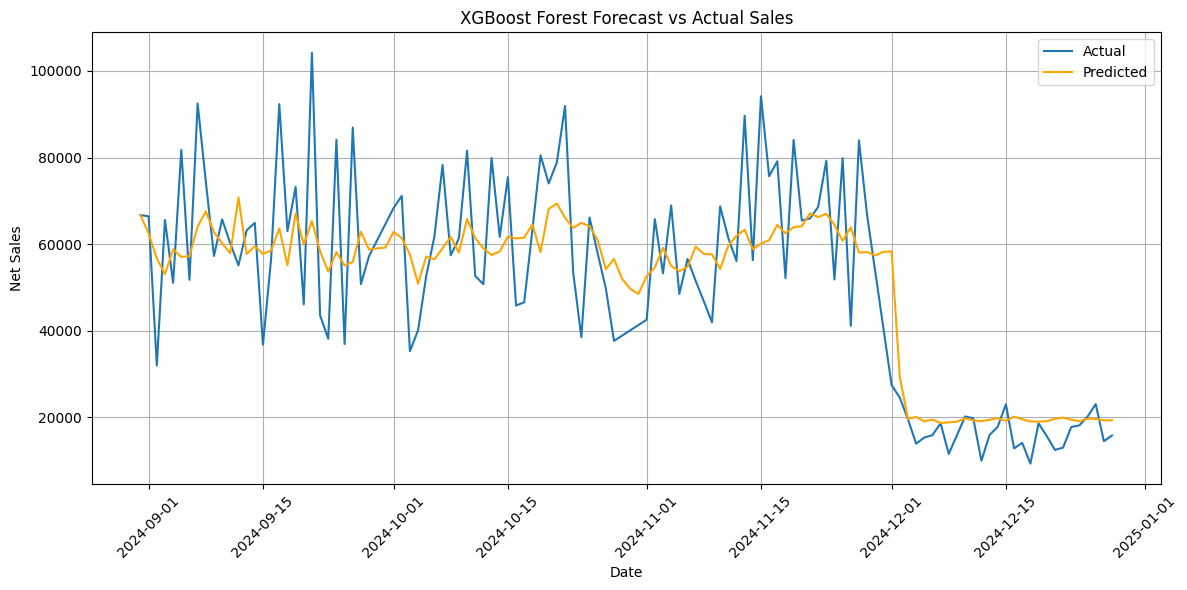

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
import optuna
import xgboost as xgb
import joblib

# Set global seed
SEED = 42
np.random.seed(SEED)

# Load and feature engineer
df = pd.read_csv("/content/Formatted_Sales_Data.csv")
df['Date'] = pd.to_datetime(df['Date'])  # Ensure Date is datetime
df['discount_rate'] = df['Discount'] / df['Sales Amount']
df['unit_price'] = df['Net Sales'] / df['Quantity']
df['quantity_discount_interaction'] = df['Quantity'] * df['Discount']
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)

# Set Date as index
df.set_index('Date', inplace=True)

# Daily aggregation
daily = df.groupby('Date').agg({
    'Net Sales': 'sum',
    'discount_rate': 'mean',
    'unit_price': 'mean',
    'quantity_discount_interaction': 'sum'
}).asfreq('D')

# Interpolate and clean
daily.interpolate(method='linear', inplace=True)
daily.dropna(inplace=True)

# Lag features
n_lags = 4
features = ['Net Sales', 'discount_rate', 'unit_price', 'quantity_discount_interaction']
for lag in range(1, n_lags + 1):
    for col in features:
        daily[f"{col}_lag{lag}"] = daily[col].shift(lag)

# Target column
daily['target'] = daily['Net Sales']
daily.dropna(inplace=True)

# Prepare features and target
X_cols = [col for col in daily.columns if 'lag' in col]
X = daily[X_cols].values
y = daily['target'].values

# Normalize input and output
x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()
X_scaled = x_scaler.fit_transform(X)
y_scaled = y_scaler.fit_transform(y.reshape(-1, 1)).ravel()

# TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Optuna objective
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 5),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 5)
    }

    rmse_scores = []
    for train_idx, test_idx in tscv.split(X_scaled):
        X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
        y_train, y_test = y_scaled[train_idx], y_scaled[test_idx]

        model = xgb.XGBRegressor(**params, random_state=SEED, n_jobs=-1, tree_method="hist")
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        rmse_scores.append(np.sqrt(mean_squared_error(y_test, preds)))

    return np.mean(rmse_scores)

# Run Optuna
sampler = optuna.samplers.TPESampler(seed=SEED)
study = optuna.create_study(direction="minimize", sampler=sampler)
study.optimize(objective, n_trials=50)

# Best params and model training
best_params = study.best_params
print("Best Parameters:", best_params)

train_idx, test_idx = list(tscv.split(X_scaled))[-1]
X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
y_train, y_test = y_scaled[train_idx], y_scaled[test_idx]

best_model = xgb.XGBRegressor(**best_params, random_state=SEED, n_jobs=-1)
best_model.fit(X_train, y_train)

# Predict and inverse transform
y_pred_scaled = best_model.predict(X_test)
y_pred = y_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()
y_test_original = y_scaler.inverse_transform(y_test.reshape(-1, 1)).ravel()

# Evaluation metrics
mae = mean_absolute_error(y_test_original, y_pred)
rmse = np.sqrt(mean_squared_error(y_test_original, y_pred))
mse = mean_squared_error(y_test_original, y_pred)
r2 = r2_score(y_test_original, y_pred)
mean_actual = np.mean(y_test_original)
normalized_mae = mae / mean_actual
normalized_rmse = rmse / mean_actual

print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}, MSE: {mse:.2f}, R²: {r2:.4f}")
print(f"Normalized MAE: {normalized_mae:.4f}, Normalized RMSE: {normalized_rmse:.4f}")

# Get actual dates for the x-axis
dates = daily.index[test_idx]

# Plot predictions vs actual with proper date labels
plt.figure(figsize=(12, 6))
plt.plot(dates, y_test_original, label='Actual')
plt.plot(dates, y_pred, label='Predicted', color='orange')
plt.title("XGBoost Forest Forecast vs Actual Sales")
plt.xlabel("Date")
plt.ylabel("Net Sales")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Optional: Save model, scalers, and data
# joblib.dump(best_model, "xgb_sales_forecast.pkl")
# joblib.dump(x_scaler, "x_scaler.pkl")
# joblib.dump(y_scaler, "y_scaler.pkl")
# daily.to_csv("daily_sales_data.csv")


## LSTM

[I 2025-04-21 10:15:37,181] A new study created in memory with name: no-name-d4e4b47c-abf8-4357-9a93-b22fd9c75736
<ipython-input-13-f590d437f217>:87: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-4, 1e-2)
[I 2025-04-21 10:15:55,840] Trial 0 finished with value: 0.10377826801159977 and parameters: {'hidden_dim': 58, 'num_layers': 3, 'dropout': 0.36599697090570255, 'lr': 0.0015751320499779737, 'batch_size': 16}. Best is trial 0 with value: 0.10377826801159977.
<ipython-input-13-f590d437f217>:87: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-4, 1e-2)
[I 2025-04-21 10:16:11,389] Trial 1 finished w

Best Parameters: {'hidden_dim': 103, 'num_layers': 1, 'dropout': 0.32932278437372, 'lr': 0.0011871252003498752, 'batch_size': 16}
MAE: 12036.54, RMSE: 16064.09, MSE: 258054992.00, R²: 0.5380
Normalized MAE: 0.2351, Normalized RMSE: 0.3138


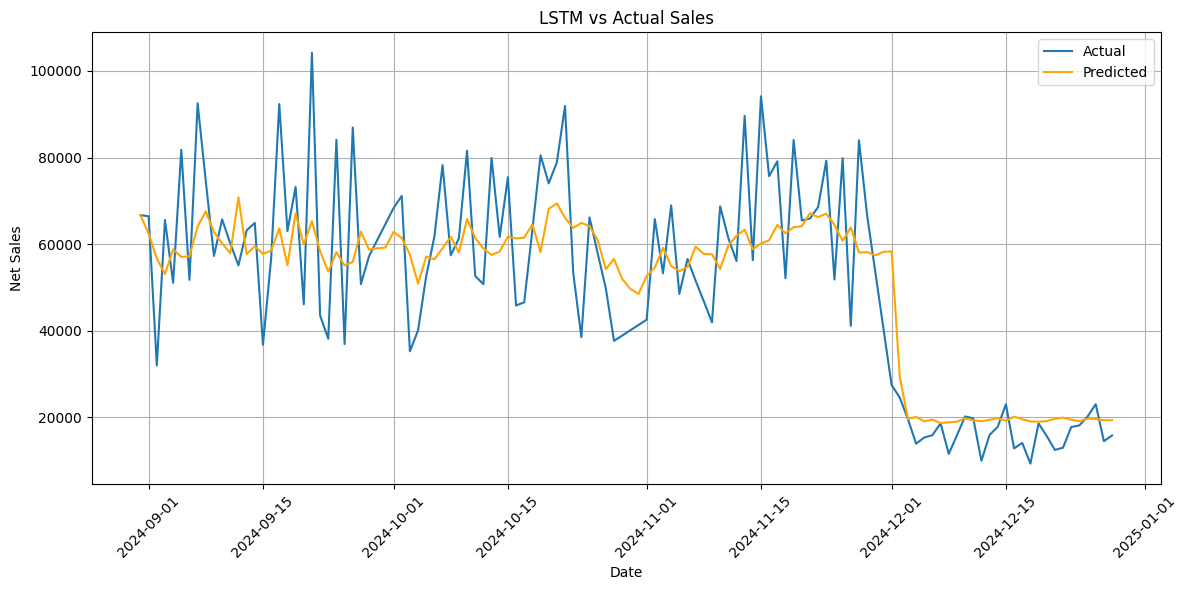

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
import optuna
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# Set global seed
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

# Load and preprocess
df = pd.read_csv("/content/Formatted_Sales_Data.csv")
df['Date'] = pd.to_datetime(df['Date'])
df['discount_rate'] = df['Discount'] / df['Sales Amount']
df['unit_price'] = df['Net Sales'] / df['Quantity']
df['quantity_discount_interaction'] = df['Quantity'] * df['Discount']
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)
df.set_index('Date', inplace=True)

# Daily aggregation
daily = df.groupby('Date').agg({
    'Net Sales': 'sum',
    'discount_rate': 'mean',
    'unit_price': 'mean',
    'quantity_discount_interaction': 'sum'
}).asfreq('D')

daily.interpolate(method='linear', inplace=True)
daily.dropna(inplace=True)

# Lag features
n_lags = 4
features = ['Net Sales', 'discount_rate', 'unit_price', 'quantity_discount_interaction']
for lag in range(1, n_lags + 1):
    for col in features:
        daily[f"{col}_lag{lag}"] = daily[col].shift(lag)

daily['target'] = daily['Net Sales']
daily.dropna(inplace=True)

X_cols = [col for col in daily.columns if 'lag' in col]
X = daily[X_cols].values
y = daily['target'].values

# Normalize
x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()
X_scaled = x_scaler.fit_transform(X)
y_scaled = y_scaler.fit_transform(y.reshape(-1, 1)).ravel()

# Dataset
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx].unsqueeze(0), self.y[idx]

# LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, dropout):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers,
                            dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

# Objective
def objective(trial):
    hidden_dim = trial.suggest_int("hidden_dim", 16, 128)
    num_layers = trial.suggest_int("num_layers", 1, 3)
    dropout = trial.suggest_float("dropout", 0.0, 0.5)
    lr = trial.suggest_loguniform("lr", 1e-4, 1e-2)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])

    tscv = TimeSeriesSplit(n_splits=5)
    rmse_scores = []

    for train_idx, test_idx in tscv.split(X_scaled):
        X_train, y_train = X_scaled[train_idx], y_scaled[train_idx]
        X_test, y_test = X_scaled[test_idx], y_scaled[test_idx]

        train_loader = DataLoader(TimeSeriesDataset(X_train, y_train), batch_size=batch_size, shuffle=False)
        test_loader = DataLoader(TimeSeriesDataset(X_test, y_test), batch_size=batch_size, shuffle=False)

        model = LSTMModel(input_dim=X.shape[1], hidden_dim=hidden_dim,
                          num_layers=num_layers, dropout=dropout)
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)

        for epoch in range(30):  # Short training for tuning
            model.train()
            for X_batch, y_batch in train_loader:
                optimizer.zero_grad()
                preds = model(X_batch)
                loss = criterion(preds, y_batch)
                loss.backward()
                optimizer.step()

        model.eval()
        preds = []
        actuals = []
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                output = model(X_batch)
                preds.append(output.numpy())
                actuals.append(y_batch.numpy())

        preds = np.vstack(preds).ravel()
        actuals = np.vstack(actuals).ravel()
        rmse = np.sqrt(mean_squared_error(actuals, preds))
        rmse_scores.append(rmse)

    return np.mean(rmse_scores)

# Run Optuna
study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(seed=SEED))
study.optimize(objective, n_trials=50)
best_params = study.best_params
print("Best Parameters:", best_params)

# Final model train on last fold
tscv = TimeSeriesSplit(n_splits=5)
train_idx, test_idx = list(tscv.split(X_scaled))[-1]
X_train, y_train = X_scaled[train_idx], y_scaled[train_idx]
X_test, y_test = X_scaled[test_idx], y_scaled[test_idx]

train_loader = DataLoader(TimeSeriesDataset(X_train, y_train), batch_size=best_params['batch_size'])
test_loader = DataLoader(TimeSeriesDataset(X_test, y_test), batch_size=best_params['batch_size'])

model = LSTMModel(input_dim=X.shape[1],
                  hidden_dim=best_params['hidden_dim'],
                  num_layers=best_params['num_layers'],
                  dropout=best_params['dropout'])
optimizer = torch.optim.Adam(model.parameters(), lr=best_params['lr'])
criterion = nn.MSELoss()

# Train final model
for epoch in range(100):
    model.train()
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        preds = model(X_batch)
        loss = criterion(preds, y_batch)
        loss.backward()
        optimizer.step()

# Predict
model.eval()
preds = []
actuals = []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        output = model(X_batch)
        preds.append(output.numpy())
        actuals.append(y_batch.numpy())

preds = y_scaler.inverse_transform(np.vstack(preds))
actuals = y_scaler.inverse_transform(np.vstack(actuals))

# Metrics
mae = mean_absolute_error(actuals, preds)
mse = mean_squared_error(actuals, preds)
rmse = np.sqrt(mse)
r2 = r2_score(actuals, preds)
normalized_mae = mae / np.mean(actuals)
normalized_rmse = rmse / np.mean(actuals)

print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}, MSE: {mse:.2f}, R²: {r2:.4f}")
print(f"Normalized MAE: {normalized_mae:.4f}, Normalized RMSE: {normalized_rmse:.4f}")

# Get actual dates for the x-axis
dates = daily.index[test_idx]

# Plot predictions vs actual with proper date labels
plt.figure(figsize=(12, 6))
plt.plot(dates, y_test_original, label='Actual')
plt.plot(dates, y_pred, label='Predicted', color='orange')
plt.title("LSTM vs Actual Sales")
plt.xlabel("Date")
plt.ylabel("Net Sales")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



## SVR

[I 2025-04-21 10:28:19,622] A new study created in memory with name: no-name-b25087b0-2496-4701-82bb-58c3c712bbef
<ipython-input-14-34ec4777a26b>:62: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "C": trial.suggest_loguniform("C", 1e-2, 1e2),
<ipython-input-14-34ec4777a26b>:63: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "epsilon": trial.suggest_loguniform("epsilon", 1e-3, 1.0),
[I 2025-04-21 10:28:19,632] Trial 0 finished with value: 0.30517198144834196 and parameters: {'C': 0.31489116479568624, 'epsilon': 0.711447600934342, 'gamma': 'scale'}. Best is trial 0 with value: 0.30517198144834196.
<ipython-input-14-34ec4777a26b>:62: FutureWarning: suggest_loguniform has be

Best SVR Parameters: {'C': 64.59924785978339, 'epsilon': 0.01233624599155376, 'gamma': 'scale'}
MAE: 3827.88, RMSE: 5088.16, MSE: 25889352.76, R²: 0.9537
Normalized MAE: 0.0748, Normalized RMSE: 0.0994


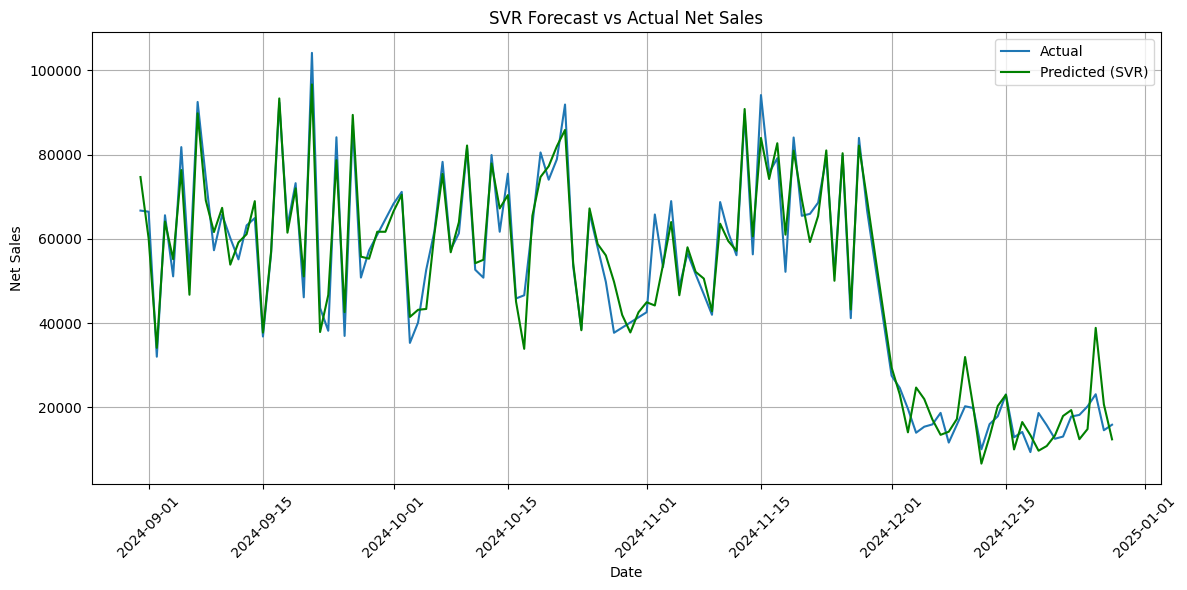

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
import optuna

# Set global seed
SEED = 42
np.random.seed(SEED)

# Load and feature engineer
df = pd.read_csv("/content/Formatted_Sales_Data.csv")
df['Date'] = pd.to_datetime(df['Date'])
df['discount_rate'] = df['Discount'] / df['Sales Amount']
df['unit_price'] = df['Net Sales'] / df['Quantity']
df['quantity_discount_interaction'] = df['Quantity'] * df['Discount']
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)
df.set_index('Date', inplace=True)

# Daily aggregation
daily = df.groupby('Date').agg({
    'Net Sales': 'sum',
    'discount_rate': 'mean',
    'unit_price': 'mean',
    'quantity_discount_interaction': 'sum'
}).asfreq('D')

daily.interpolate(method='linear', inplace=True)
daily.dropna(inplace=True)

# Lag features
n_lags = 4
features = ['Net Sales', 'discount_rate', 'unit_price', 'quantity_discount_interaction']
for lag in range(1, n_lags + 1):
    for col in features:
        daily[f"{col}_lag{lag}"] = daily[col].shift(lag)

daily['target'] = daily['Net Sales']
daily.dropna(inplace=True)

# Prepare features and target
X_cols = [col for col in daily.columns if 'lag' in col]
X = daily[X_cols].values
y = daily['target'].values

# Normalize features and target
x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()
X_scaled = x_scaler.fit_transform(X)
y_scaled = y_scaler.fit_transform(y.reshape(-1, 1)).ravel()

# TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Optuna objective for SVR
def svr_objective(trial):
    params = {
        "C": trial.suggest_loguniform("C", 1e-2, 1e2),
        "epsilon": trial.suggest_loguniform("epsilon", 1e-3, 1.0),
        "gamma": trial.suggest_categorical("gamma", ["scale", "auto"]),
        "kernel": "rbf"
    }

    rmse_scores = []
    for train_idx, test_idx in tscv.split(X_scaled):
        X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
        y_train, y_test = y_scaled[train_idx], y_scaled[test_idx]

        model = SVR(**params)
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        rmse_scores.append(np.sqrt(mean_squared_error(y_test, preds)))

    return np.mean(rmse_scores)

# Run Optuna
study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(seed=SEED))
study.optimize(svr_objective, n_trials=50)

# Best parameters and final model training
best_params = study.best_params
print("Best SVR Parameters:", best_params)

train_idx, test_idx = list(tscv.split(X_scaled))[-1]
X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
y_train, y_test = y_scaled[train_idx], y_scaled[test_idx]

svr_model = SVR(**best_params)
svr_model.fit(X_train, y_train)

# Predictions and inverse transform
y_pred_scaled = svr_model.predict(X_test)
y_pred = y_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()
y_test_original = y_scaler.inverse_transform(y_test.reshape(-1, 1)).ravel()

# Metrics
mae = mean_absolute_error(y_test_original, y_pred)
rmse = np.sqrt(mean_squared_error(y_test_original, y_pred))
mse = mean_squared_error(y_test_original, y_pred)
r2 = r2_score(y_test_original, y_pred)
mean_actual = np.mean(y_test_original)
normalized_mae = mae / mean_actual
normalized_rmse = rmse / mean_actual

print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}, MSE: {mse:.2f}, R²: {r2:.4f}")
print(f"Normalized MAE: {normalized_mae:.4f}, Normalized RMSE: {normalized_rmse:.4f}")

# Plot results
dates = daily.index[test_idx]
plt.figure(figsize=(12, 6))
plt.plot(dates, y_test_original, label='Actual')
plt.plot(dates, y_pred, label='Predicted (SVR)', color='green')
plt.title("SVR Forecast vs Actual Net Sales")
plt.xlabel("Date")
plt.ylabel("Net Sales")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## svr + rf

[I 2025-04-21 10:30:04,195] A new study created in memory with name: no-name-8a8c0559-6578-41f3-92ab-2853c7aa132e
<ipython-input-15-623bba2bca1c>:70: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  svr_c = trial.suggest_loguniform('svr_c', 1e-2, 1e2)
<ipython-input-15-623bba2bca1c>:71: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  svr_eps = trial.suggest_loguniform('svr_epsilon', 1e-3, 1.0)
[I 2025-04-21 10:30:04,914] Trial 0 finished with value: 0.18682289121437273 and parameters: {'svr_c': 0.31489116479568624, 'svr_epsilon': 0.711447600934342, 'svr_kernel': 'rbf', 'rf_n_estimators': 73, 'rf_max_depth': 3}. Best is trial 0 with value: 0.18682289121437273.
<ipython-input-

Best Hyperparameters: {'svr_c': 1.4388087798160827, 'svr_epsilon': 0.10649073722016299, 'svr_kernel': 'linear', 'rf_n_estimators': 112, 'rf_max_depth': 14}
MAE: 10378.08, RMSE: 12579.32, MSE: 158239221.03, R²: 0.7154
Normalized MAE: 0.2022, Normalized RMSE: 0.2451


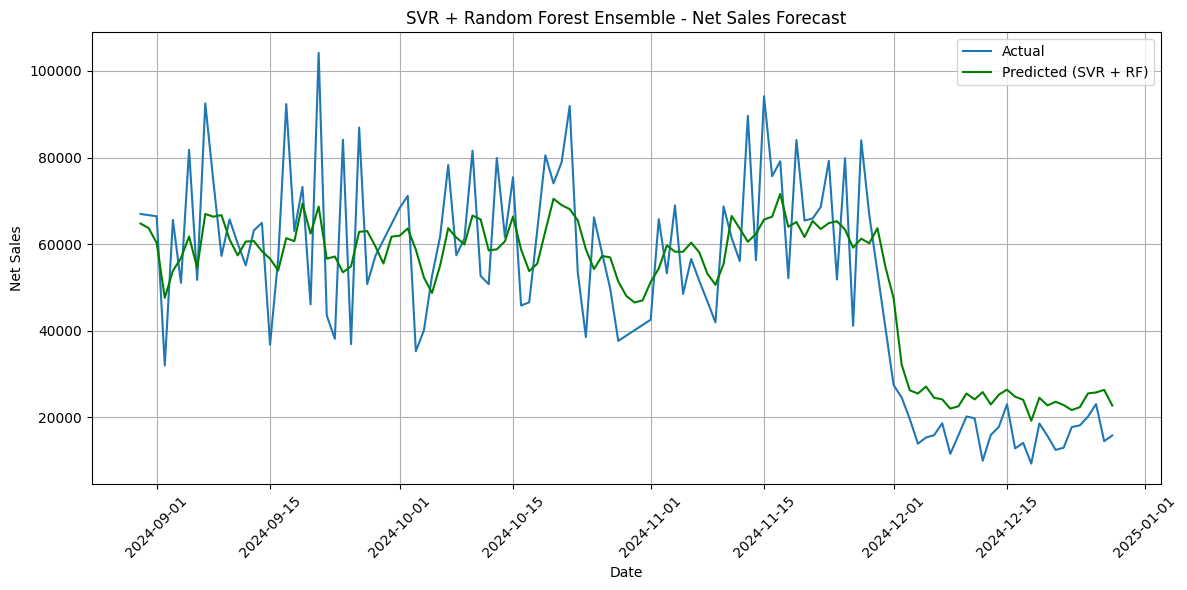

In [15]:
# !pip install optuna
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
import optuna
import joblib

# Set global seed
SEED = 42
np.random.seed(SEED)

# Load and preprocess dataset
df = pd.read_csv("/content/Formatted_Sales_Data.csv")
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df.sort_index(inplace=True)

# Feature engineering
df['discount_rate'] = df['Discount'] / df['Sales Amount']
df['unit_price'] = df['Net Sales'] / df['Quantity']
df['quantity_discount_interaction'] = df['Quantity'] * df['Discount']
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)

# Aggregate to daily
daily = df.groupby('Date').agg({
    'Net Sales': 'sum',
    'discount_rate': 'mean',
    'unit_price': 'mean',
    'quantity_discount_interaction': 'sum'
}).asfreq('D')

# Fill missing days using interpolation
daily.interpolate(method='linear', inplace=True)
daily.dropna(inplace=True)

# Lag features
n_lags = 2
features = ['Net Sales', 'discount_rate', 'unit_price', 'quantity_discount_interaction']
for lag in range(1, n_lags + 1):
    for col in features:
        daily[f"{col}_lag{lag}"] = daily[col].shift(lag)

# Define target
daily['target'] = daily['Net Sales']
daily.dropna(subset=['target'] + [col for col in daily.columns if 'lag' in col], inplace=True)

# Prepare input and output
X_cols = [col for col in daily.columns if 'lag' in col]
X = daily[X_cols].values
y = daily['target'].values

# Normalize input and output
x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()
X_scaled = x_scaler.fit_transform(X)
y_scaled = y_scaler.fit_transform(y.reshape(-1, 1)).ravel()

# TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Optuna objective function for ensemble
def objective(trial):
    # SVR hyperparameters
    svr_c = trial.suggest_loguniform('svr_c', 1e-2, 1e2)
    svr_eps = trial.suggest_loguniform('svr_epsilon', 1e-3, 1.0)
    svr_kernel = trial.suggest_categorical('svr_kernel', ['rbf', 'linear', 'poly'])

    # RF hyperparameters
    rf_n = trial.suggest_int('rf_n_estimators', 50, 200)
    rf_depth = trial.suggest_int('rf_max_depth', 3, 15)

    rmse_scores = []
    for train_idx, test_idx in tscv.split(X_scaled):
        X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
        y_train, y_test = y_scaled[train_idx], y_scaled[test_idx]

        svr = SVR(C=svr_c, epsilon=svr_eps, kernel=svr_kernel)
        rf = RandomForestRegressor(n_estimators=rf_n, max_depth=rf_depth, random_state=SEED, n_jobs=-1)

        svr.fit(X_train, y_train)
        rf.fit(X_train, y_train)

        preds_svr = svr.predict(X_test)
        preds_rf = rf.predict(X_test)

        ensemble_preds = (preds_svr + preds_rf) / 2
        rmse_scores.append(np.sqrt(mean_squared_error(y_test, ensemble_preds)))

    return np.mean(rmse_scores)

# Run Optuna
sampler = optuna.samplers.TPESampler(seed=SEED)
study = optuna.create_study(direction="minimize", sampler=sampler)
study.optimize(objective, n_trials=50)

# Train final models using last fold
best_params = study.best_params
print("Best Hyperparameters:", best_params)

train_idx, test_idx = list(tscv.split(X_scaled))[-1]
X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
y_train, y_test = y_scaled[train_idx], y_scaled[test_idx]

# Final models
svr_final = SVR(
    C=best_params['svr_c'],
    epsilon=best_params['svr_epsilon'],
    kernel=best_params['svr_kernel']
)

rf_final = RandomForestRegressor(
    n_estimators=best_params['rf_n_estimators'],
    max_depth=best_params['rf_max_depth'],
    random_state=SEED,
    n_jobs=-1
)

# Train models
svr_final.fit(X_train, y_train)
rf_final.fit(X_train, y_train)

# Ensemble prediction
pred_svr = svr_final.predict(X_test)
pred_rf = rf_final.predict(X_test)
ensemble_pred_scaled = (pred_svr + pred_rf) / 2

# Inverse transform predictions
y_pred = y_scaler.inverse_transform(ensemble_pred_scaled.reshape(-1, 1)).ravel()
y_test_original = y_scaler.inverse_transform(y_test.reshape(-1, 1)).ravel()

# Evaluation
mae = mean_absolute_error(y_test_original, y_pred)
rmse = np.sqrt(mean_squared_error(y_test_original, y_pred))
mse = mean_squared_error(y_test_original, y_pred)
r2 = r2_score(y_test_original, y_pred)
mean_actual = np.mean(y_test_original)
normalized_mae = mae / mean_actual
normalized_rmse = rmse / mean_actual

print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}, MSE: {mse:.2f}, R²: {r2:.4f}")
print(f"Normalized MAE: {normalized_mae:.4f}, Normalized RMSE: {normalized_rmse:.4f}")

# Plot predictions
dates = daily.index[test_idx]
plt.figure(figsize=(12, 6))
plt.plot(dates, y_test_original, label='Actual')
plt.plot(dates, y_pred, label='Predicted (SVR + RF)', color='green')
plt.title("SVR + Random Forest Ensemble - Net Sales Forecast")
plt.xlabel("Date")
plt.ylabel("Net Sales")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Save models and scalers if needed
# joblib.dump(svr_final, "svr_model.pkl")
# joblib.dump(rf_final, "rf_model.pkl")
# joblib.dump(x_scaler, "x_scaler.pkl")
# joblib.dump(y_scaler, "y_scaler.pkl")
# daily.to_csv("daily_sales_data.csv")


## Lstm+ svr+RF

[I 2025-04-21 10:32:51,129] A new study created in memory with name: no-name-e97afc44-0410-4f8d-a19b-9e7a82419c8f
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


[I 2025-04-21 10:33:13,315] Trial 0 finished with value: 0.05482773854876072 and parameters: {'n_estimators': 182, 'max_depth': 13, 'svr_C': 1.4314420177237033, 'svr_eps': 0.002246105298444988, 'weight_rf': 0.4425018823938244, 'weight_svr': 0.3903666664465987}. Best is trial 0 with value: 0.05482773854876072.
[I 2025-04-21 10:33:13,317] Trial 1 finished with value: inf and parameters: {'n_estimators': 133, 'max_depth': 5, 'svr_C': 0.8370050230866848, 'svr_eps': 0.008108560619376575, 'weight_rf': 0.5320424838882275, 'weight_svr': 0.5655794304201017}. Best is trial 0 with value: 0.05482773854876072.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stoppin

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


[I 2025-04-21 10:33:31,950] Trial 2 finished with value: 0.06205059556675241 and parameters: {'n_estimators': 144, 'max_depth': 6, 'svr_C': 0.5731080143683358, 'svr_eps': 0.04947607406134379, 'weight_rf': 0.158346831019875, 'weight_svr': 0.6789118169742328}. Best is trial 0 with value: 0.05482773854876072.
[I 2025-04-21 10:33:31,953] Trial 3 finished with value: inf and parameters: {'n_estimators': 55, 'max_depth': 9, 'svr_C': 6.447836263256273, 'svr_eps': 0.06453373861626949, 'weight_rf': 0.6900781406017916, 'weight_svr': 0.8677768418541949}. Best is trial 0 with value: 0.05482773854876072.
[I 2025-04-21 10:33:31,955] Trial 4 finished with value: inf and parameters: {'n_estimators': 67, 'max_depth': 7, 'svr_C': 6.482125953814777, 'svr_eps': 0.04121338490551888, 'weight_rf': 0.3251133279270546, 'weight_svr': 0.935143822889102}. Best is trial 0 with value: 0.05482773854876072.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_sha

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


[I 2025-04-21 10:33:50,511] Trial 5 finished with value: 0.06545975739626184 and parameters: {'n_estimators': 86, 'max_depth': 13, 'svr_C': 0.7281459296983932, 'svr_eps': 0.07370690785558674, 'weight_rf': 0.08255448368917895, 'weight_svr': 0.8582061254914062}. Best is trial 0 with value: 0.05482773854876072.
[I 2025-04-21 10:33:50,515] Trial 6 finished with value: inf and parameters: {'n_estimators': 96, 'max_depth': 10, 'svr_C': 0.41662423065045695, 'svr_eps': 0.040020287267607625, 'weight_rf': 0.684119960491728, 'weight_svr': 0.3269159274728948}. Best is trial 0 with value: 0.05482773854876072.
[I 2025-04-21 10:33:50,517] Trial 7 finished with value: inf and parameters: {'n_estimators': 129, 'max_depth': 14, 'svr_C': 0.16982393868935328, 'svr_eps': 0.05284168963297522, 'weight_rf': 0.882291306300581, 'weight_svr': 0.5075834817780208}. Best is trial 0 with value: 0.05482773854876072.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


[I 2025-04-21 10:34:09,458] Trial 8 finished with value: 0.06993428056819356 and parameters: {'n_estimators': 70, 'max_depth': 10, 'svr_C': 7.490933511106116, 'svr_eps': 0.01288484329109212, 'weight_rf': 0.08606159467764596, 'weight_svr': 0.06061461763220266}. Best is trial 0 with value: 0.05482773854876072.
[I 2025-04-21 10:34:09,461] Trial 9 finished with value: inf and parameters: {'n_estimators': 141, 'max_depth': 15, 'svr_C': 2.126222020898091, 'svr_eps': 0.007543530765067621, 'weight_rf': 0.6710623904200732, 'weight_svr': 0.5958110259646736}. Best is trial 0 with value: 0.05482773854876072.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


[I 2025-04-21 10:34:28,328] Trial 10 finished with value: 0.06482957454747822 and parameters: {'n_estimators': 187, 'max_depth': 3, 'svr_C': 1.9616946425705164, 'svr_eps': 0.09345188794641107, 'weight_rf': 0.3373289215907718, 'weight_svr': 0.27594164724713455}. Best is trial 0 with value: 0.05482773854876072.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


[I 2025-04-21 10:34:48,105] Trial 11 finished with value: 0.05846535644622621 and parameters: {'n_estimators': 179, 'max_depth': 12, 'svr_C': 0.30895880085617805, 'svr_eps': 0.029849814176559183, 'weight_rf': 0.2940062397712, 'weight_svr': 0.6975644561964139}. Best is trial 0 with value: 0.05482773854876072.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


[I 2025-04-21 10:35:07,076] Trial 12 finished with value: 0.0593037630525029 and parameters: {'n_estimators': 200, 'max_depth': 12, 'svr_C': 0.10130402671420269, 'svr_eps': 0.02497376220516663, 'weight_rf': 0.3524096702911813, 'weight_svr': 0.34423026305513843}. Best is trial 0 with value: 0.05482773854876072.
[I 2025-04-21 10:35:07,101] Trial 13 finished with value: inf and parameters: {'n_estimators': 171, 'max_depth': 12, 'svr_C': 0.31655424401221577, 'svr_eps': 0.023583829673186767, 'weight_rf': 0.4863819940339077, 'weight_svr': 0.7034142390398528}. Best is trial 0 with value: 0.05482773854876072.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early sto

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


[I 2025-04-21 10:35:26,431] Trial 14 finished with value: 0.0623022603815186 and parameters: {'n_estimators': 166, 'max_depth': 11, 'svr_C': 1.9811522479041488, 'svr_eps': 0.02741836783842925, 'weight_rf': 0.2494148912304246, 'weight_svr': 0.1651837440057245}. Best is trial 0 with value: 0.05482773854876072.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


[I 2025-04-21 10:35:46,023] Trial 15 finished with value: 0.054527518201723885 and parameters: {'n_estimators': 163, 'max_depth': 15, 'svr_C': 0.2415280204567465, 'svr_eps': 0.004534025378917289, 'weight_rf': 0.5143692697080676, 'weight_svr': 0.4336859303067935}. Best is trial 15 with value: 0.054527518201723885.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


[I 2025-04-21 10:36:10,562] Trial 16 finished with value: 0.053531174612433285 and parameters: {'n_estimators': 159, 'max_depth': 15, 'svr_C': 1.231502868663043, 'svr_eps': 0.004847466480841008, 'weight_rf': 0.5063370752654885, 'weight_svr': 0.41333876379687345}. Best is trial 16 with value: 0.053531174612433285.
[I 2025-04-21 10:36:10,624] Trial 17 finished with value: inf and parameters: {'n_estimators': 158, 'max_depth': 15, 'svr_C': 3.7457609983376403, 'svr_eps': 0.016738925018275987, 'weight_rf': 0.9706172864333669, 'weight_svr': 0.43732730995442926}. Best is trial 16 with value: 0.053531174612433285.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Earl

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


[I 2025-04-21 10:36:32,277] Trial 18 finished with value: 0.05385233766029579 and parameters: {'n_estimators': 111, 'max_depth': 15, 'svr_C': 0.18036073010538792, 'svr_eps': 0.0025085441034056063, 'weight_rf': 0.5915326678677817, 'weight_svr': 0.23042187327486496}. Best is trial 16 with value: 0.053531174612433285.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


[I 2025-04-21 10:36:50,597] Trial 19 finished with value: 0.05820953142856717 and parameters: {'n_estimators': 112, 'max_depth': 8, 'svr_C': 0.11404053481920548, 'svr_eps': 0.08917005305505096, 'weight_rf': 0.7924505858300243, 'weight_svr': 0.1770884276646814}. Best is trial 16 with value: 0.053531174612433285.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


[I 2025-04-21 10:37:09,786] Trial 20 finished with value: 0.054921922585730164 and parameters: {'n_estimators': 112, 'max_depth': 14, 'svr_C': 1.3217171515842359, 'svr_eps': 0.017236456041897757, 'weight_rf': 0.6378379527063155, 'weight_svr': 0.011578883954439956}. Best is trial 16 with value: 0.053531174612433285.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


[I 2025-04-21 10:37:29,270] Trial 21 finished with value: 0.05444254239741225 and parameters: {'n_estimators': 156, 'max_depth': 15, 'svr_C': 0.1942359475426647, 'svr_eps': 0.0015020012499789666, 'weight_rf': 0.5622509469426562, 'weight_svr': 0.2283925030841788}. Best is trial 16 with value: 0.053531174612433285.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


[I 2025-04-21 10:37:49,295] Trial 22 finished with value: 0.05467013839947175 and parameters: {'n_estimators': 149, 'max_depth': 14, 'svr_C': 0.17658531191743063, 'svr_eps': 0.015569720607268207, 'weight_rf': 0.5756721874507655, 'weight_svr': 0.22128155409089803}. Best is trial 16 with value: 0.053531174612433285.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


[I 2025-04-21 10:38:08,585] Trial 23 finished with value: 0.0587719424878023 and parameters: {'n_estimators': 104, 'max_depth': 13, 'svr_C': 0.6071473818663868, 'svr_eps': 0.0042717912360583365, 'weight_rf': 0.432658284794893, 'weight_svr': 0.08236079230520332}. Best is trial 16 with value: 0.053531174612433285.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


[I 2025-04-21 10:38:26,998] Trial 24 finished with value: 0.053213865919192506 and parameters: {'n_estimators': 120, 'max_depth': 15, 'svr_C': 0.42391434553854584, 'svr_eps': 0.012847167864765544, 'weight_rf': 0.6050402934223836, 'weight_svr': 0.2683021517325521}. Best is trial 24 with value: 0.053213865919192506.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


[I 2025-04-21 10:38:46,226] Trial 25 finished with value: 0.052190046838355895 and parameters: {'n_estimators': 120, 'max_depth': 14, 'svr_C': 0.44008900501322207, 'svr_eps': 0.03654255494461747, 'weight_rf': 0.7719209070542545, 'weight_svr': 0.13216253882689166}. Best is trial 25 with value: 0.052190046838355895.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


[I 2025-04-21 10:39:04,544] Trial 26 finished with value: 0.05177317768515169 and parameters: {'n_estimators': 122, 'max_depth': 14, 'svr_C': 1.0697779303722785, 'svr_eps': 0.03565870641448764, 'weight_rf': 0.7932197155566497, 'weight_svr': 0.12832231495091326}. Best is trial 26 with value: 0.05177317768515169.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


[I 2025-04-21 10:39:22,944] Trial 27 finished with value: 0.0539805696050105 and parameters: {'n_estimators': 122, 'max_depth': 11, 'svr_C': 0.46544601729680185, 'svr_eps': 0.03610229936564662, 'weight_rf': 0.7880930003415645, 'weight_svr': 0.10680523817453456}. Best is trial 26 with value: 0.05177317768515169.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


[I 2025-04-21 10:39:41,497] Trial 28 finished with value: 0.05299783678099391 and parameters: {'n_estimators': 90, 'max_depth': 13, 'svr_C': 0.9649512104202366, 'svr_eps': 0.04906392580616323, 'weight_rf': 0.7923329805952163, 'weight_svr': 0.0008437020184115795}. Best is trial 26 with value: 0.05177317768515169.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


[I 2025-04-21 10:40:00,749] Trial 29 finished with value: 0.053080642971226076 and parameters: {'n_estimators': 84, 'max_depth': 13, 'svr_C': 1.0505090899832878, 'svr_eps': 0.05297847212781254, 'weight_rf': 0.7930464729719341, 'weight_svr': 0.005206385283686244}. Best is trial 26 with value: 0.05177317768515169.


Best hyperparameters: {'n_estimators': 122, 'max_depth': 14, 'svr_C': 1.0697779303722785, 'svr_eps': 0.03565870641448764, 'weight_rf': 0.7932197155566497, 'weight_svr': 0.12832231495091326}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
MAE: 7291.62, RMSE: 9700.32, R²: 0.8458
Normalized MAE (by mean): 0.1546, Normalized RMSE (by mean): 0.2056
Weights => RF: 0.79, SVR: 0.13, LSTM: 0.08


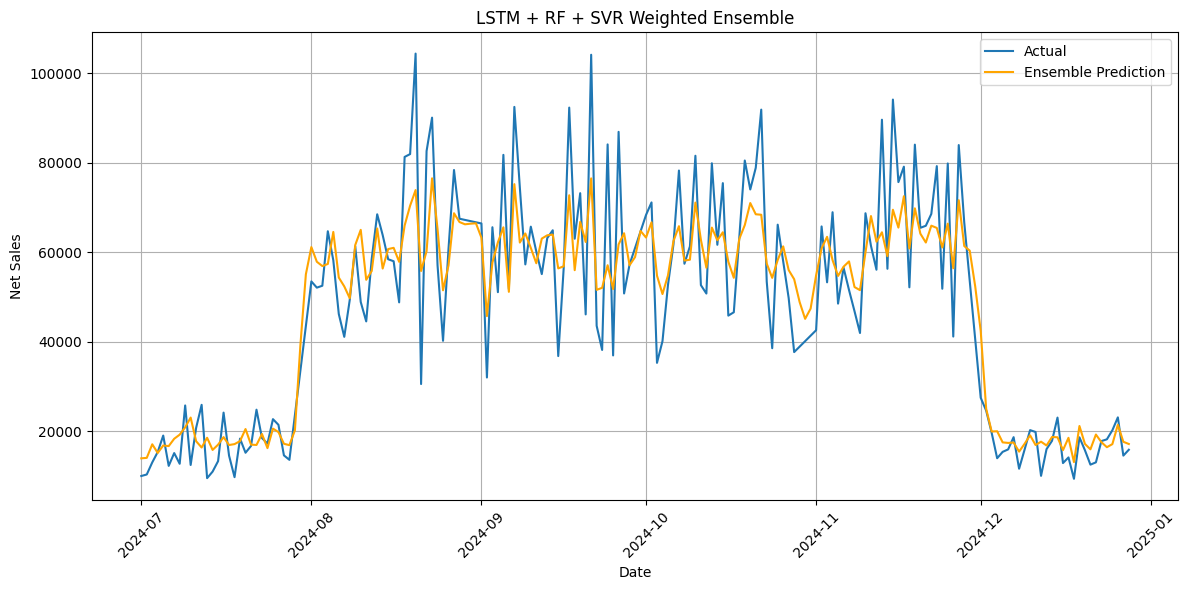

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import optuna
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

# Fix seed
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Load data
df = pd.read_csv("/content/Formatted_Sales_Data.csv")
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df.sort_index(inplace=True)

# Feature engineering
df['discount_rate'] = df['Discount'] / df['Sales Amount']
df['unit_price'] = df['Net Sales'] / df['Quantity']
df['quantity_discount_interaction'] = df['Quantity'] * df['Discount']
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)

# Daily aggregation
daily = df.groupby('Date').agg({
    'Net Sales': 'sum',
    'discount_rate': 'mean',
    'unit_price': 'mean',
    'quantity_discount_interaction': 'sum'
}).asfreq('D')

daily.interpolate(method='linear', inplace=True)
daily.dropna(inplace=True)

# Lag features
n_lags = 2
features = ['Net Sales', 'discount_rate', 'unit_price', 'quantity_discount_interaction']
for lag in range(1, n_lags + 1):
    for col in features:
        daily[f"{col}_lag{lag}"] = daily[col].shift(lag)

daily['target'] = daily['Net Sales']
daily.dropna(inplace=True)

X_cols = [col for col in daily.columns if 'lag' in col]
X = daily[X_cols].values
y = daily['target'].values

x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()
X_scaled = x_scaler.fit_transform(X)
y_scaled = y_scaler.fit_transform(y.reshape(-1, 1)).ravel()

# Prepare LSTM sequences
def create_lstm_data(X, y, timesteps=1):
    Xs, ys = [], []
    for i in range(timesteps, len(X)):
        Xs.append(X[i - timesteps:i])
        ys.append(y[i])
    return np.array(Xs), np.array(ys)

timesteps = 2
X_lstm, y_lstm = create_lstm_data(X_scaled, y_scaled, timesteps)
X_rf_svr = X_scaled[timesteps:]
y_rf_svr = y_scaled[timesteps:]

tscv = TimeSeriesSplit(n_splits=3)

# Objective for Optuna
def objective(trial):
    rf = RandomForestRegressor(
        n_estimators=trial.suggest_int("n_estimators", 50, 200),
        max_depth=trial.suggest_int("max_depth", 3, 15),
        random_state=SEED,
        n_jobs=-1
    )

    svr = SVR(
        C=trial.suggest_float("svr_C", 0.1, 10.0, log=True),
        epsilon=trial.suggest_float("svr_eps", 0.001, 0.1)
    )

    weight_rf = trial.suggest_float("weight_rf", 0.0, 1.0)
    weight_svr = trial.suggest_float("weight_svr", 0.0, 1.0)
    weight_lstm = 1.0 - weight_rf - weight_svr
    if weight_lstm < 0: return float("inf")

    mae_scores = []
    for train_idx, test_idx in tscv.split(X_rf_svr):
        # RF and SVR
        X_train_rf, X_test_rf = X_rf_svr[train_idx], X_rf_svr[test_idx]
        y_train_rf, y_test_rf = y_rf_svr[train_idx], y_rf_svr[test_idx]
        rf.fit(X_train_rf, y_train_rf)
        svr.fit(X_train_rf, y_train_rf)
        rf_preds = rf.predict(X_test_rf)
        svr_preds = svr.predict(X_test_rf)

        # LSTM
        X_train_lstm, X_test_lstm = X_lstm[train_idx], X_lstm[test_idx]
        y_train_lstm, y_test_lstm = y_lstm[train_idx], y_lstm[test_idx]
        model = Sequential([
            LSTM(32, input_shape=(timesteps, X.shape[1])),
            Dense(1)
        ])
        model.compile(optimizer='adam', loss='mse')
        model.fit(X_train_lstm, y_train_lstm, epochs=30, batch_size=16, verbose=0,
                  callbacks=[EarlyStopping(patience=5, restore_best_weights=True)])

        lstm_preds = model.predict(X_test_lstm).ravel()

        ensemble_pred = (weight_rf * rf_preds +
                         weight_svr * svr_preds +
                         weight_lstm * lstm_preds)

        mae = mean_absolute_error(y_test_rf, ensemble_pred)
        mae_scores.append(mae)

    return np.mean(mae_scores)

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=30)
print("Best hyperparameters:", study.best_params)

# Train final models
best_params = study.best_params
weight_rf = best_params["weight_rf"]
weight_svr = best_params["weight_svr"]
weight_lstm = 1.0 - weight_rf - weight_svr

rf = RandomForestRegressor(
    n_estimators=best_params["n_estimators"],
    max_depth=best_params["max_depth"],
    random_state=SEED,
    n_jobs=-1
)

svr = SVR(
    C=best_params["svr_C"],
    epsilon=best_params["svr_eps"]
)

# Use last split for final test
train_idx, test_idx = list(tscv.split(X_rf_svr))[-1]
X_train_rf, X_test_rf = X_rf_svr[train_idx], X_rf_svr[test_idx]
y_train_rf, y_test_rf = y_rf_svr[train_idx], y_rf_svr[test_idx]

X_train_lstm, X_test_lstm = X_lstm[train_idx], X_lstm[test_idx]
y_train_lstm, y_test_lstm = y_lstm[train_idx], y_lstm[test_idx]

rf.fit(X_train_rf, y_train_rf)
svr.fit(X_train_rf, y_train_rf)

model = Sequential([
    LSTM(32, input_shape=(timesteps, X.shape[1])),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
model.fit(X_train_lstm, y_train_lstm, epochs=30, batch_size=16, verbose=0,
          callbacks=[EarlyStopping(patience=5, restore_best_weights=True)])

# Predictions
rf_preds = rf.predict(X_test_rf)
svr_preds = svr.predict(X_test_rf)
lstm_preds = model.predict(X_test_lstm).ravel()

ensemble_pred_scaled = (weight_rf * rf_preds +
                        weight_svr * svr_preds +
                        weight_lstm * lstm_preds)

y_test_original = y_scaler.inverse_transform(y_test_rf.reshape(-1, 1)).ravel()
y_pred_original = y_scaler.inverse_transform(ensemble_pred_scaled.reshape(-1, 1)).ravel()

# Metrics
mae = mean_absolute_error(y_test_original, y_pred_original)
rmse = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
r2 = r2_score(y_test_original, y_pred_original)

# Normalized metrics using mean of actual values
mean_actual = np.mean(y_test_original)
nrmse = rmse / mean_actual
nmae = mae / mean_actual

print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.4f}")
print(f"Normalized MAE (by mean): {nmae:.4f}, Normalized RMSE (by mean): {nrmse:.4f}")
print(f"Weights => RF: {weight_rf:.2f}, SVR: {weight_svr:.2f}, LSTM: {weight_lstm:.2f}")

# Plot
dates = daily.index[timesteps:][test_idx]
plt.figure(figsize=(12, 6))
plt.plot(dates, y_test_original, label="Actual")
plt.plot(dates, y_pred_original, label="Ensemble Prediction", color="orange")
plt.xlabel("Date")
plt.ylabel("Net Sales")
plt.title("LSTM + RF + SVR Weighted Ensemble")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## quantity pediction

## SVR

[I 2025-04-21 11:05:14,604] A new study created in memory with name: no-name-99fb9404-e69c-48ff-8148-952aaf25dd0b
<ipython-input-17-f05679c2859d>:72: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "C": trial.suggest_loguniform("C", 1e-2, 1e2),
<ipython-input-17-f05679c2859d>:73: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "epsilon": trial.suggest_loguniform("epsilon", 1e-3, 1.0),
[I 2025-04-21 11:05:14,614] Trial 0 finished with value: 0.2659709079854528 and parameters: {'C': 0.31489116479568624, 'epsilon': 0.711447600934342, 'gamma': 'scale'}. Best is trial 0 with value: 0.2659709079854528.
<ipython-input-17-f05679c2859d>:72: FutureWarning: suggest_loguniform has been

Best SVR Parameters: {'C': 4.318606282053512, 'epsilon': 0.012507093503885004, 'gamma': 'auto'}

--- Final Evaluation for 'Cafe Mocha' ---
MAE: 1.72, RMSE: 2.41, MSE: 5.81, R²: 0.8281
Normalized MAE: 0.1418, Normalized RMSE: 0.1989


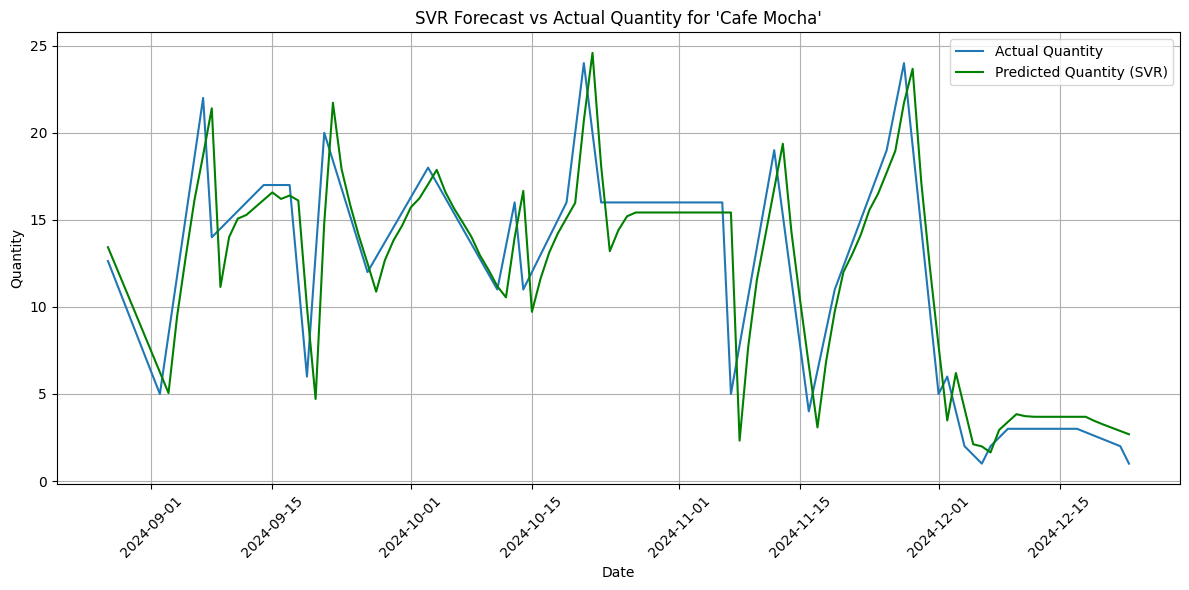

In [17]:
!pip install optuna
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
import optuna

# Set global seed
SEED = 42
np.random.seed(SEED)

# Load dataset
df = pd.read_csv("/content/Formatted_Sales_Data.csv")
df['Date'] = pd.to_datetime(df['Date'])

# Select an individual item
selected_item = "Cafe Mocha"  # Change this to another item if needed
df = df[df["Item Name"] == selected_item].copy()

# Feature engineering
df['discount_rate'] = df['Discount'] / df['Sales Amount']
df['unit_price'] = df['Net Sales'] / df['Quantity']
df['quantity_discount_interaction'] = df['Quantity'] * df['Discount']
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)
df.set_index('Date', inplace=True)

# Daily aggregation
daily = df.groupby('Date').agg({
    'Quantity': 'sum',
    'Discount': 'sum',
    'Sales Amount': 'sum',
    'Net Sales': 'sum',
    'discount_rate': 'mean',
    'unit_price': 'mean',
    'quantity_discount_interaction': 'sum'
}).asfreq('D')

daily.interpolate(method='linear', inplace=True)
daily.dropna(inplace=True)

# Lag features
n_lags = 4
features = ['Discount', 'Sales Amount', 'Net Sales', 'discount_rate', 'unit_price', 'quantity_discount_interaction']
for lag in range(1, n_lags + 1):
    for col in features:
        daily[f"{col}_lag{lag}"] = daily[col].shift(lag)

daily['target'] = daily['Quantity']
daily.dropna(inplace=True)

# Prepare features and target
X_cols = [col for col in daily.columns if 'lag' in col]
X = daily[X_cols].values
y = daily['target'].values

# Scale features and target
x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()
X_scaled = x_scaler.fit_transform(X)
y_scaled = y_scaler.fit_transform(y.reshape(-1, 1)).ravel()

# TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Optuna objective
def svr_objective(trial):
    params = {
        "C": trial.suggest_loguniform("C", 1e-2, 1e2),
        "epsilon": trial.suggest_loguniform("epsilon", 1e-3, 1.0),
        "gamma": trial.suggest_categorical("gamma", ["scale", "auto"]),
        "kernel": "rbf"
    }

    rmse_scores = []
    for train_idx, test_idx in tscv.split(X_scaled):
        X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
        y_train, y_test = y_scaled[train_idx], y_scaled[test_idx]

        model = SVR(**params)
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        rmse_scores.append(np.sqrt(mean_squared_error(y_test, preds)))

    return np.mean(rmse_scores)

# Run Optuna
study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(seed=SEED))
study.optimize(svr_objective, n_trials=50)

# Best parameters
best_params = study.best_params
print("Best SVR Parameters:", best_params)

# Final train/test split
train_idx, test_idx = list(tscv.split(X_scaled))[-1]
X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
y_train, y_test = y_scaled[train_idx], y_scaled[test_idx]

# Train final SVR model
svr_model = SVR(**best_params)
svr_model.fit(X_train, y_train)

# Predict and inverse transform
y_pred_scaled = svr_model.predict(X_test)
y_pred = y_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()
y_test_original = y_scaler.inverse_transform(y_test.reshape(-1, 1)).ravel()

# Metrics
mae = mean_absolute_error(y_test_original, y_pred)
rmse = np.sqrt(mean_squared_error(y_test_original, y_pred))
mse = mean_squared_error(y_test_original, y_pred)
r2 = r2_score(y_test_original, y_pred)
mean_actual = np.mean(y_test_original)
normalized_mae = mae / mean_actual
normalized_rmse = rmse / mean_actual

print(f"\n--- Final Evaluation for '{selected_item}' ---")
print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}, MSE: {mse:.2f}, R²: {r2:.4f}")
print(f"Normalized MAE: {normalized_mae:.4f}, Normalized RMSE: {normalized_rmse:.4f}")

# Plot: Actual vs Predicted Quantity
dates = daily.index[test_idx]
plt.figure(figsize=(12, 6))
plt.plot(dates, y_test_original, label='Actual Quantity')
plt.plot(dates, y_pred, label='Predicted Quantity (SVR)', color='green')
plt.title(f"SVR Forecast vs Actual Quantity for '{selected_item}'")
plt.xlabel("Date")
plt.ylabel("Quantity")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## random forest

[I 2025-04-21 11:05:40,782] A new study created in memory with name: no-name-1ce16d2c-baef-46bf-aaf4-8c86ccf41ef9
[I 2025-04-21 11:05:42,939] Trial 0 finished with value: 0.060834229111690674 and parameters: {'n_estimators': 144, 'max_depth': 20, 'min_samples_split': 8, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.060834229111690674.
[I 2025-04-21 11:05:44,044] Trial 1 finished with value: 0.059270503344707036 and parameters: {'n_estimators': 89, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 5}. Best is trial 1 with value: 0.059270503344707036.
[I 2025-04-21 11:05:46,767] Trial 2 finished with value: 0.058273563634697656 and parameters: {'n_estimators': 200, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 5}. Best is trial 2 with value: 0.058273563634697656.
[I 2025-04-21 11:05:51,107] Trial 3 finished with value: 0.06427081531880958 and parameters: {'n_estimators': 258, 'max_depth': 6, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 2 

Best RF Parameters: {'n_estimators': 151, 'max_depth': 19, 'min_samples_split': 10, 'min_samples_leaf': 5}

--- Final Evaluation for 'Cafe Mocha' using Random Forest ---
MAE: 1.46, RMSE: 2.24, MSE: 5.00, R²: 0.8522
Normalized MAE: 0.1203, Normalized RMSE: 0.1844


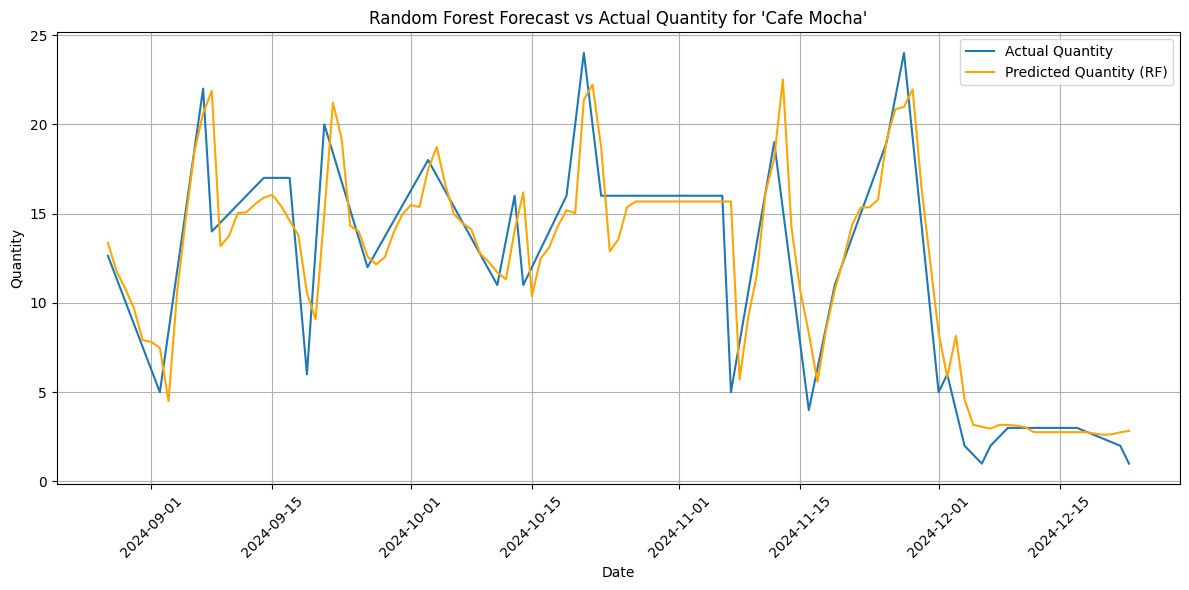

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
import optuna

# Set seed
SEED = 42
np.random.seed(SEED)

# Load dataset
df = pd.read_csv("/content/Formatted_Sales_Data.csv")
df['Date'] = pd.to_datetime(df['Date'])

# Select specific item
selected_item = "Cafe Mocha"  # change as needed
df = df[df["Item Name"] == selected_item].copy()

# Feature engineering
df['discount_rate'] = df['Discount'] / df['Sales Amount']
df['unit_price'] = df['Net Sales'] / df['Quantity']
df['quantity_discount_interaction'] = df['Quantity'] * df['Discount']
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)
df.set_index('Date', inplace=True)

# Daily aggregation
daily = df.groupby('Date').agg({
    'Quantity': 'sum',
    'Discount': 'sum',
    'Sales Amount': 'sum',
    'Net Sales': 'sum',
    'discount_rate': 'mean',
    'unit_price': 'mean',
    'quantity_discount_interaction': 'sum'
}).asfreq('D')

daily.interpolate(method='linear', inplace=True)
daily.dropna(inplace=True)

# Lag features
n_lags = 4
features = ['Discount', 'Sales Amount', 'Net Sales', 'discount_rate', 'unit_price', 'quantity_discount_interaction']
for lag in range(1, n_lags + 1):
    for col in features:
        daily[f"{col}_lag{lag}"] = daily[col].shift(lag)

daily['target'] = daily['Quantity']
daily.dropna(inplace=True)

# Prepare inputs
X_cols = [col for col in daily.columns if 'lag' in col]
X = daily[X_cols].values
y = daily['target'].values

# Scaling
x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()
X_scaled = x_scaler.fit_transform(X)
y_scaled = y_scaler.fit_transform(y.reshape(-1, 1)).ravel()

# Cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Optuna objective function for Random Forest
def rf_objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 300),
        "max_depth": trial.suggest_int("max_depth", 3, 20),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 5),
        "random_state": SEED,
        "n_jobs": -1
    }

    rmse_scores = []
    for train_idx, test_idx in tscv.split(X_scaled):
        X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
        y_train, y_test = y_scaled[train_idx], y_scaled[test_idx]

        model = RandomForestRegressor(**params)
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        rmse_scores.append(np.sqrt(mean_squared_error(y_test, preds)))

    return np.mean(rmse_scores)

# Run Optuna
study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(seed=SEED))
study.optimize(rf_objective, n_trials=50)

# Best parameters
best_params = study.best_params
print("Best RF Parameters:", best_params)

# Final split
train_idx, test_idx = list(tscv.split(X_scaled))[-1]
X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
y_train, y_test = y_scaled[train_idx], y_scaled[test_idx]

# Train final RF model
rf_model = RandomForestRegressor(**best_params)
rf_model.fit(X_train, y_train)

# Predict and inverse transform
y_pred_scaled = rf_model.predict(X_test)
y_pred = y_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()
y_test_original = y_scaler.inverse_transform(y_test.reshape(-1, 1)).ravel()

# Metrics
mae = mean_absolute_error(y_test_original, y_pred)
rmse = np.sqrt(mean_squared_error(y_test_original, y_pred))
mse = mean_squared_error(y_test_original, y_pred)
r2 = r2_score(y_test_original, y_pred)
mean_actual = np.mean(y_test_original)
normalized_mae = mae / mean_actual
normalized_rmse = rmse / mean_actual

print(f"\n--- Final Evaluation for '{selected_item}' using Random Forest ---")
print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}, MSE: {mse:.2f}, R²: {r2:.4f}")
print(f"Normalized MAE: {normalized_mae:.4f}, Normalized RMSE: {normalized_rmse:.4f}")

# Plot
dates = daily.index[test_idx]
plt.figure(figsize=(12, 6))
plt.plot(dates, y_test_original, label='Actual Quantity')
plt.plot(dates, y_pred, label='Predicted Quantity (RF)', color='orange')
plt.title(f"Random Forest Forecast vs Actual Quantity for '{selected_item}'")
plt.xlabel("Date")
plt.ylabel("Quantity")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## LSTM

[I 2025-04-21 11:26:34,806] A new study created in memory with name: no-name-42ad81ae-b260-4ee3-877c-28baa63540ec
[I 2025-04-21 11:26:54,394] Trial 0 finished with value: 0.11936170223529437 and parameters: {'seq_len': 11, 'hidden_size': 29, 'num_layers': 2, 'lr': 0.00011789010962863706, 'batch_size': 32}. Best is trial 0 with value: 0.11936170223529437.
[I 2025-04-21 11:27:22,869] Trial 1 finished with value: 0.11750700886790992 and parameters: {'seq_len': 11, 'hidden_size': 20, 'num_layers': 3, 'lr': 0.0003130767024540462, 'batch_size': 16}. Best is trial 1 with value: 0.11750700886790992.
[I 2025-04-21 11:27:32,484] Trial 2 finished with value: 0.09044908512743169 and parameters: {'seq_len': 5, 'hidden_size': 51, 'num_layers': 2, 'lr': 0.004068186443630895, 'batch_size': 32}. Best is trial 2 with value: 0.09044908512743169.
[I 2025-04-21 11:27:50,274] Trial 3 finished with value: 0.08531203348335835 and parameters: {'seq_len': 8, 'hidden_size': 55, 'num_layers': 3, 'lr': 0.006772343

Best LSTM Parameters: {'seq_len': 14, 'hidden_size': 45, 'num_layers': 2, 'lr': 0.007359132757678865, 'batch_size': 32}

--- Final Evaluation for 'Cafe Mocha' using LSTM ---
MAE: 2.79, RMSE: 3.68, R²: 0.6066
Normalized MAE: 0.2299, Normalized RMSE: 0.3034


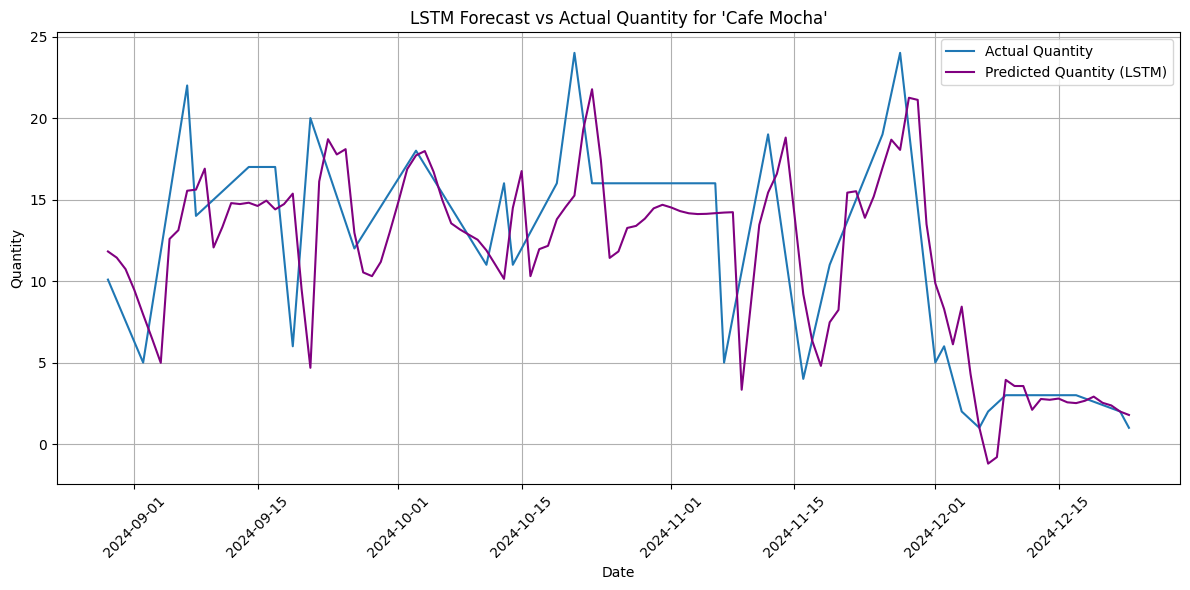

In [5]:
!pip install optuna
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
import optuna
from torch.utils.data import DataLoader, TensorDataset

# Set seed
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

# Load and preprocess
df = pd.read_csv("/content/Formatted_Sales_Data.csv")
df['Date'] = pd.to_datetime(df['Date'])

# Filter by item
selected_item = "Cafe Mocha"
df = df[df["Item Name"] == selected_item].copy()

# Feature engineering
df['discount_rate'] = df['Discount'] / df['Sales Amount']
df['unit_price'] = df['Net Sales'] / df['Quantity']
df['quantity_discount_interaction'] = df['Quantity'] * df['Discount']
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)
df.set_index('Date', inplace=True)

# Daily aggregation
daily = df.groupby('Date').agg({
    'Quantity': 'sum',
    'Discount': 'sum',
    'Sales Amount': 'sum',
    'Net Sales': 'sum',
    'discount_rate': 'mean',
    'unit_price': 'mean',
    'quantity_discount_interaction': 'sum'
}).asfreq('D')

daily.interpolate(method='linear', inplace=True)
daily.dropna(inplace=True)

# Lag features
n_lags = 4
features = ['Discount', 'Sales Amount', 'Net Sales', 'discount_rate', 'unit_price', 'quantity_discount_interaction']
for lag in range(1, n_lags + 1):
    for col in features:
        daily[f"{col}_lag{lag}"] = daily[col].shift(lag)

daily['target'] = daily['Quantity']
daily.dropna(inplace=True)

# Prepare inputs
X_cols = [col for col in daily.columns if 'lag' in col]
X = daily[X_cols].values
y = daily['target'].values

# Scaling
x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()
X_scaled = x_scaler.fit_transform(X)
y_scaled = y_scaler.fit_transform(y.reshape(-1, 1)).ravel()

# Sequence generation for LSTM
def create_sequences(X, y, seq_len):
    Xs, ys = [], []
    for i in range(len(X) - seq_len):
        Xs.append(X[i:i+seq_len])
        ys.append(y[i+seq_len])
    return np.array(Xs), np.array(ys)

# Optuna objective
def lstm_objective(trial):
    seq_len = trial.suggest_int("seq_len", 5, 15)
    hidden_size = trial.suggest_int("hidden_size", 16, 64)
    num_layers = trial.suggest_int("num_layers", 1, 3)
    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])
    epochs = 30

    # Prepare sequences
    X_seq, y_seq = create_sequences(X_scaled, y_scaled, seq_len)
    tscv = TimeSeriesSplit(n_splits=5)
    rmse_scores = []

    for train_idx, test_idx in tscv.split(X_seq):
        X_train, X_test = X_seq[train_idx], X_seq[test_idx]
        y_train, y_test = y_seq[train_idx], y_seq[test_idx]

        train_loader = DataLoader(TensorDataset(
            torch.Tensor(X_train), torch.Tensor(y_train)), batch_size=batch_size, shuffle=False)
        test_loader = DataLoader(TensorDataset(
            torch.Tensor(X_test), torch.Tensor(y_test)), batch_size=batch_size, shuffle=False)

        # Define model
        class LSTMModel(nn.Module):
            def __init__(self):
                super().__init__()
                self.lstm = nn.LSTM(
                    input_size=X_seq.shape[2],
                    hidden_size=hidden_size,
                    num_layers=num_layers,
                    batch_first=True
                )
                self.fc = nn.Linear(hidden_size, 1)

            def forward(self, x):
                out, _ = self.lstm(x)
                out = self.fc(out[:, -1, :])
                return out.squeeze()

        model = LSTMModel()
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        criterion = nn.MSELoss()

        for epoch in range(epochs):
            model.train()
            for xb, yb in train_loader:
                optimizer.zero_grad()
                preds = model(xb)
                loss = criterion(preds, yb)
                loss.backward()
                optimizer.step()

        # Evaluation
        model.eval()
        preds = []
        with torch.no_grad():
            for xb, _ in test_loader:
                preds.append(model(xb).numpy())
        preds = np.concatenate(preds)
        rmse = np.sqrt(mean_squared_error(y_seq[test_idx], preds))
        rmse_scores.append(rmse)

    return np.mean(rmse_scores)

# Run Optuna
study = optuna.create_study(direction="minimize")
study.optimize(lstm_objective, n_trials=30)

# Best parameters
best_params = study.best_params
print("Best LSTM Parameters:", best_params)

# Final training
seq_len = best_params['seq_len']
X_seq, y_seq = create_sequences(X_scaled, y_scaled, seq_len)
train_idx, test_idx = list(TimeSeriesSplit(n_splits=5).split(X_seq))[-1]
X_train, X_test = X_seq[train_idx], X_seq[test_idx]
y_train, y_test = y_seq[train_idx], y_seq[test_idx]

train_loader = DataLoader(TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train)), batch_size=best_params['batch_size'])
test_loader = DataLoader(TensorDataset(torch.Tensor(X_test), torch.Tensor(y_test)), batch_size=best_params['batch_size'])

class FinalLSTM(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=X_seq.shape[2],
            hidden_size=best_params['hidden_size'],
            num_layers=best_params['num_layers'],
            batch_first=True
        )
        self.fc = nn.Linear(best_params['hidden_size'], 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out.squeeze()

final_model = FinalLSTM()
optimizer = torch.optim.Adam(final_model.parameters(), lr=best_params['lr'])
criterion = nn.MSELoss()

for epoch in range(30):
    final_model.train()
    for xb, yb in train_loader:
        optimizer.zero_grad()
        preds = final_model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()

# Predictions
final_model.eval()
preds = []
with torch.no_grad():
    for xb, _ in test_loader:
        preds.append(final_model(xb).numpy())
preds = np.concatenate(preds)

# Inverse scaling
y_pred = y_scaler.inverse_transform(preds.reshape(-1, 1)).ravel()
y_test_orig = y_scaler.inverse_transform(y_test.reshape(-1, 1)).ravel()

# Metrics
mae = mean_absolute_error(y_test_orig, y_pred)
rmse = np.sqrt(mean_squared_error(y_test_orig, y_pred))
r2 = r2_score(y_test_orig, y_pred)
normalized_mae = mae / np.mean(y_test_orig)
normalized_rmse = rmse / np.mean(y_test_orig)

print(f"\n--- Final Evaluation for '{selected_item}' using LSTM ---")
print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.4f}")
print(f"Normalized MAE: {normalized_mae:.4f}, Normalized RMSE: {normalized_rmse:.4f}")

# Plot
dates = daily.index[-len(y_test):]
plt.figure(figsize=(12, 6))
plt.plot(dates, y_test_orig, label="Actual Quantity")
plt.plot(dates, y_pred, label="Predicted Quantity (LSTM)", color="purple")
plt.title(f"LSTM Forecast vs Actual Quantity for '{selected_item}'")
plt.xlabel("Date")
plt.ylabel("Quantity")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


## XGBoost

[I 2025-04-20 19:29:11,318] A new study created in memory with name: no-name-30fe3dd8-51d4-4b34-ada2-defd538bca07
[I 2025-04-20 19:29:14,529] Trial 0 finished with value: 0.10663389801997303 and parameters: {'n_estimators': 144, 'max_depth': 12, 'learning_rate': 0.22227824312530747, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.6624074561769746, 'gamma': 0.7799726016810132, 'reg_alpha': 0.05808361216819946, 'reg_lambda': 1.7992642186624028}. Best is trial 0 with value: 0.10663389801997303.
[I 2025-04-20 19:29:21,246] Trial 1 finished with value: 0.11775567775065561 and parameters: {'n_estimators': 200, 'max_depth': 10, 'learning_rate': 0.01596950334578271, 'subsample': 0.9879639408647978, 'colsample_bytree': 0.9329770563201687, 'gamma': 1.0616955533913808, 'reg_alpha': 0.18182496720710062, 'reg_lambda': 0.7751067647801507}. Best is trial 0 with value: 0.10663389801997303.
[I 2025-04-20 19:29:23,304] Trial 2 finished with value: 0.10993969471277769 and parameters: {'n_estimator

Best XGBoost Parameters: {'n_estimators': 286, 'max_depth': 6, 'learning_rate': 0.2876636145107665, 'subsample': 0.6252172369548645, 'colsample_bytree': 0.894692223926801, 'gamma': 0.012413606513402316, 'reg_alpha': 0.1914405913183066, 'reg_lambda': 1.7260529911188935}

--- Final Evaluation for 'Cafe Mocha' using XGBoost ---
MAE: 1.15, RMSE: 1.43, MSE: 2.05, R²: 0.9249
Normalized MAE: 0.0914, Normalized RMSE: 0.1139


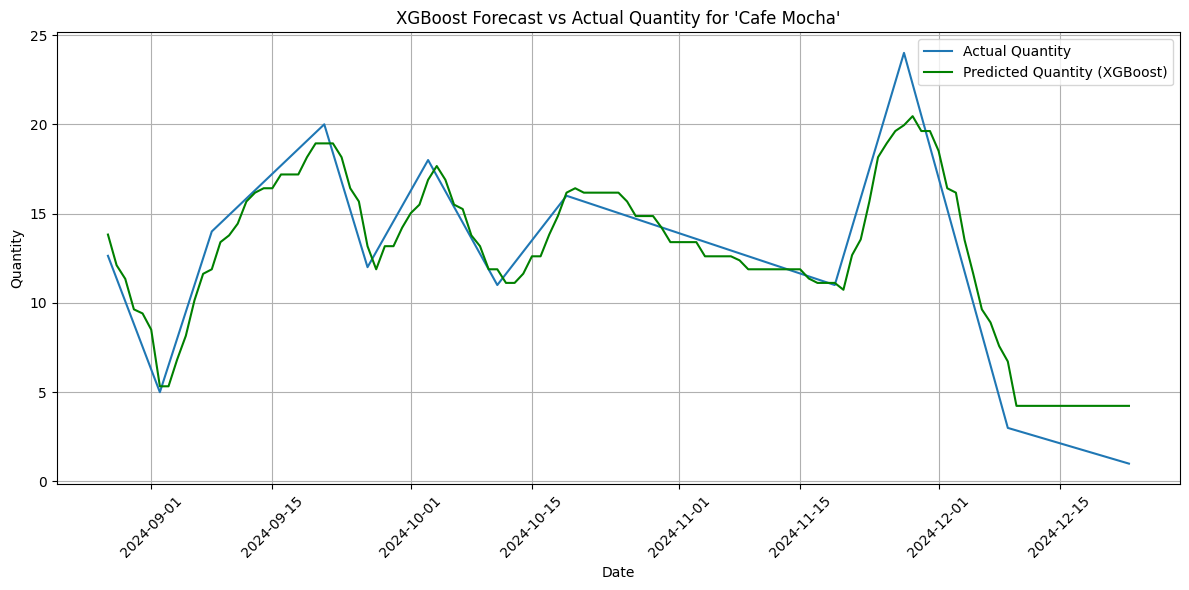

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
import optuna

# Set seed
SEED = 42
np.random.seed(SEED)

# Load dataset
df = pd.read_csv("/content/Formatted_Sales_Data.csv")
df['Date'] = pd.to_datetime(df['Date'])

# Select specific item
selected_item = "Cafe Mocha"
df = df[df["Item Name"] == selected_item].copy()

# Feature engineering
df['discount_rate'] = df['Discount'] / df['Sales Amount']
df['unit_price'] = df['Net Sales'] / df['Quantity']
df['quantity_discount_interaction'] = df['Quantity'] * df['Discount']
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)
df.set_index('Date', inplace=True)

# Daily aggregation
daily = df.groupby('Date').agg({
    'Quantity': 'sum',
    'Discount': 'sum',
    'Sales Amount': 'sum',
    'Net Sales': 'sum',
    'discount_rate': 'mean',
    'unit_price': 'mean',
    'quantity_discount_interaction': 'sum'
}).asfreq('D')

daily.interpolate(method='linear', inplace=True)
daily.dropna(inplace=True)

# Lag features
n_lags = 4
features = ['Discount', 'Sales Amount', 'Net Sales', 'discount_rate', 'unit_price', 'quantity_discount_interaction']
for lag in range(1, n_lags + 1):
    for col in features:
        daily[f"{col}_lag{lag}"] = daily[col].shift(lag)

daily['target'] = daily['Quantity']
daily.dropna(inplace=True)

# Prepare inputs
X_cols = [col for col in daily.columns if 'lag' in col]
X = daily[X_cols].values
y = daily['target'].values

# Scaling
x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()
X_scaled = x_scaler.fit_transform(X)
y_scaled = y_scaler.fit_transform(y.reshape(-1, 1)).ravel()

# TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Optuna objective
def xgb_objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 300),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 5),
        "reg_alpha": trial.suggest_float("reg_alpha", 0, 1),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.5, 2.0),
        "random_state": SEED
    }

    rmse_scores = []
    for train_idx, test_idx in tscv.split(X_scaled):
        X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
        y_train, y_test = y_scaled[train_idx], y_scaled[test_idx]

        model = XGBRegressor(**params, verbosity=0)
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        rmse_scores.append(np.sqrt(mean_squared_error(y_test, preds)))

    return np.mean(rmse_scores)

# Run Optuna
study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(seed=SEED))
study.optimize(xgb_objective, n_trials=50)

# Best parameters
best_params = study.best_params
print("Best XGBoost Parameters:", best_params)

# Final split
train_idx, test_idx = list(tscv.split(X_scaled))[-1]
X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
y_train, y_test = y_scaled[train_idx], y_scaled[test_idx]

# Final model
xgb_model = XGBRegressor(**best_params, verbosity=0)
xgb_model.fit(X_train, y_train)

# Predict and inverse transform
y_pred_scaled = xgb_model.predict(X_test)
y_pred = y_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()
y_test_original = y_scaler.inverse_transform(y_test.reshape(-1, 1)).ravel()

# Metrics
mae = mean_absolute_error(y_test_original, y_pred)
rmse = np.sqrt(mean_squared_error(y_test_original, y_pred))
mse = mean_squared_error(y_test_original, y_pred)
r2 = r2_score(y_test_original, y_pred)
mean_actual = np.mean(y_test_original)
normalized_mae = mae / mean_actual
normalized_rmse = rmse / mean_actual

print(f"\n--- Final Evaluation for '{selected_item}' using XGBoost ---")
print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}, MSE: {mse:.2f}, R²: {r2:.4f}")
print(f"Normalized MAE: {normalized_mae:.4f}, Normalized RMSE: {normalized_rmse:.4f}")

# Plot results
dates = daily.index[test_idx]
plt.figure(figsize=(12, 6))
plt.plot(dates, y_test_original, label='Actual Quantity')
plt.plot(dates, y_pred, label='Predicted Quantity (XGBoost)', color='green')
plt.title(f"XGBoost Forecast vs Actual Quantity for '{selected_item}'")
plt.xlabel("Date")
plt.ylabel("Quantity")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
